In [1]:
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, GridSearchCV
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer,KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt

# Download data

In [2]:
data = pd.read_csv('./data/orange_small_churn_train_data.csv')

In [3]:
data.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18299 entries, 0 to 18298
Columns: 232 entries, ID to labels
dtypes: float64(192), int64(2), object(38)
memory usage: 32.4+ MB


In [5]:
# check null in features
dict_nan = {name: np.sum(data[name].isnull()) for name in data.columns}
dict_nan

{'ID': 0,
 'Var1': 18038,
 'Var2': 17831,
 'Var3': 17832,
 'Var4': 17736,
 'Var5': 17799,
 'Var6': 1991,
 'Var7': 1976,
 'Var8': 18299,
 'Var9': 18038,
 'Var10': 17799,
 'Var11': 17832,
 'Var12': 18085,
 'Var13': 1976,
 'Var14': 17832,
 'Var15': 18299,
 'Var16': 17799,
 'Var17': 17736,
 'Var18': 17736,
 'Var19': 17736,
 'Var20': 18299,
 'Var21': 1991,
 'Var22': 1792,
 'Var23': 17799,
 'Var24': 2616,
 'Var25': 1792,
 'Var26': 17799,
 'Var27': 17799,
 'Var28': 1793,
 'Var29': 18038,
 'Var30': 18038,
 'Var31': 18299,
 'Var32': 18299,
 'Var33': 18010,
 'Var34': 17831,
 'Var35': 1792,
 'Var36': 17831,
 'Var37': 17736,
 'Var38': 1792,
 'Var39': 18299,
 'Var40': 17831,
 'Var41': 18038,
 'Var42': 18299,
 'Var43': 17831,
 'Var44': 1792,
 'Var45': 18171,
 'Var46': 17831,
 'Var47': 18038,
 'Var48': 18299,
 'Var49': 17831,
 'Var50': 18038,
 'Var51': 16888,
 'Var52': 18299,
 'Var53': 18038,
 'Var54': 17831,
 'Var55': 18299,
 'Var56': 18055,
 'Var57': 0,
 'Var58': 18038,
 'Var59': 17990,
 'Var60': 1

In [6]:
# check disbalance in classes
print(data['labels'].value_counts())
print(data['labels'].unique())

-1.0    16921
 1.0     1377
Name: labels, dtype: int64
[-1.  1. nan]


In [7]:
data['labels'].replace(-1, 0, inplace=True)
data.dropna(subset=['labels'], inplace=True)
labels = data['labels']
data = data.iloc[:,:-1]

methods simple feature selection

1. Drop feature with nans more half of data done
2. Calc corr between feature and drop with high corr
3. drop almost constat feature

Compare methods:

1. use mutual info for cat feature
2. binary classification
3. corr between cat feature and labels
4. interative algo
5. method is based on models



# Simple preprocessing feature

In [8]:
# drop feture with null more half of dataset
def check_feat_without(data, columns, threshold = 0):
    flag_nan_col = [np.sum(data[name].isnull()) < threshold for name in columns]
    return columns[flag_nan_col]
    

In [9]:
numeric_col = data.columns[1:190]
cat_col = data.columns[190:]
print(len(numeric_col))
print(len(cat_col))

189
41


In [10]:
right_numeric_column = check_feat_without(data, numeric_col, threshold = len(data)//2)
right_cat_column = check_feat_without(data, cat_col, threshold = len(data)//2)
print(len(right_numeric_column))
print(len(right_cat_column))

41
28


In [11]:
# check unique in cat feat
for cur_cat in right_cat_column:
    count_uniq = len(data[cur_cat].unique())
    print(f'{cur_cat}: {count_uniq}')

Var192: 326
Var193: 44
Var195: 21
Var196: 4
Var197: 207
Var198: 2721
Var199: 2639
Var202: 4673
Var203: 4
Var204: 100
Var205: 4
Var206: 22
Var207: 12
Var208: 3
Var210: 6
Var211: 2
Var212: 71
Var216: 1247
Var217: 7944
Var218: 3
Var219: 20
Var220: 2721
Var221: 7
Var222: 2721
Var223: 5
Var226: 23
Var227: 7
Var228: 29


In [12]:
# check unique in num feat
for cur_num in right_numeric_column:
    count_uniq = len(data[cur_num].unique())
    print(f'{cur_num}: {count_uniq}')

Var6: 1039
Var7: 7
Var13: 1877
Var21: 498
Var22: 498
Var24: 63
Var25: 190
Var28: 2513
Var35: 10
Var38: 11908
Var44: 6
Var57: 14013
Var65: 13
Var72: 9
Var73: 129
Var74: 284
Var76: 11377
Var78: 13
Var81: 15952
Var83: 130
Var85: 109
Var94: 8571
Var109: 149
Var112: 158
Var113: 17900
Var119: 1003
Var123: 191
Var125: 6217
Var126: 52
Var132: 18
Var133: 14165
Var134: 12639
Var140: 1859
Var143: 5
Var144: 11
Var149: 7524
Var153: 14567
Var160: 273
Var163: 9049
Var173: 4
Var181: 7


Visualisathion numeric

In [13]:
corr_map = data[right_numeric_column].corr(method='spearman')

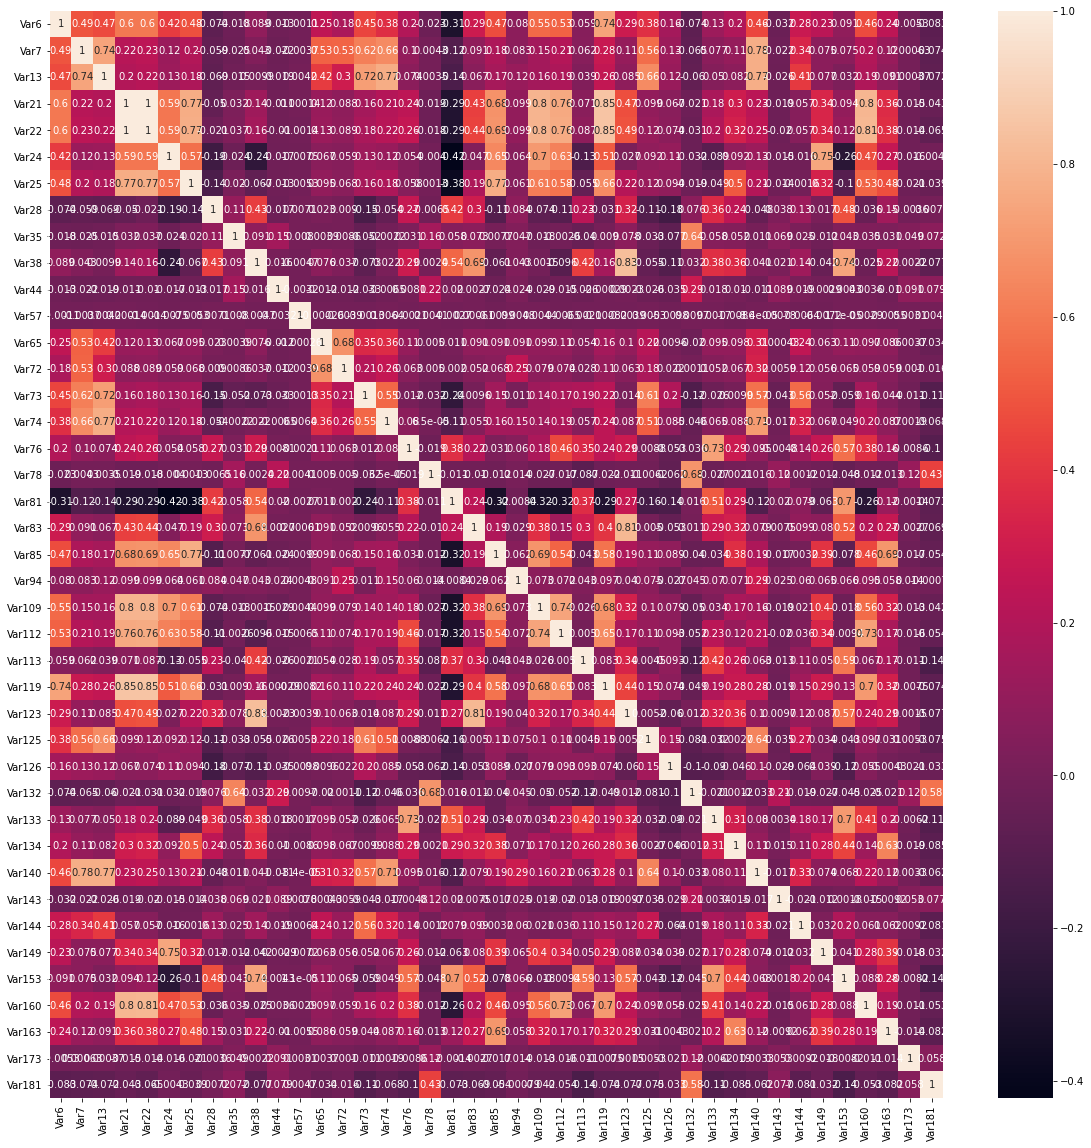

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(corr_map, annot=True)
plt.show()

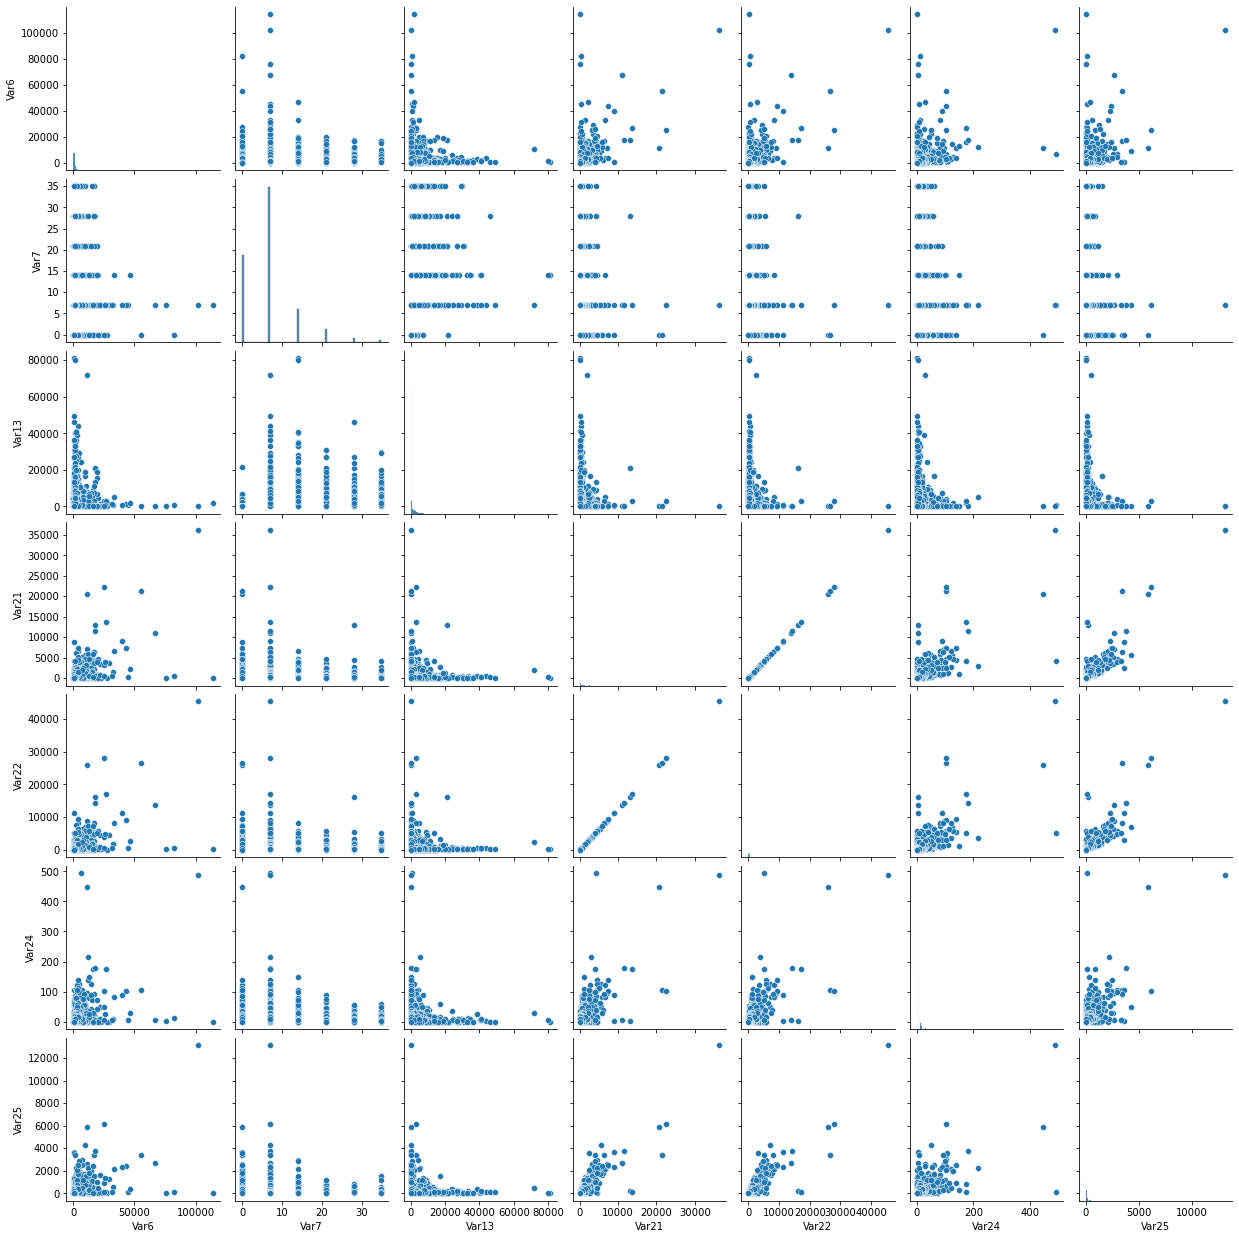

In [21]:
sns.pairplot(data[right_numeric_column[:7]])

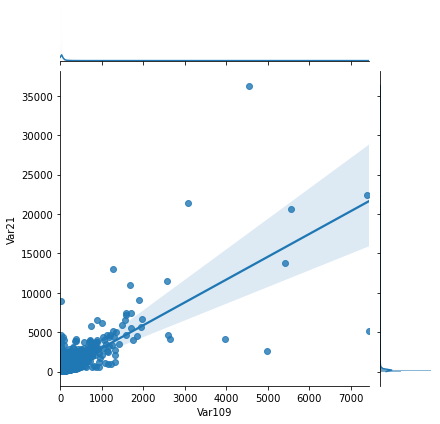

In [20]:
sns.jointplot(x="Var109", y="Var21", data=data, kind='reg')

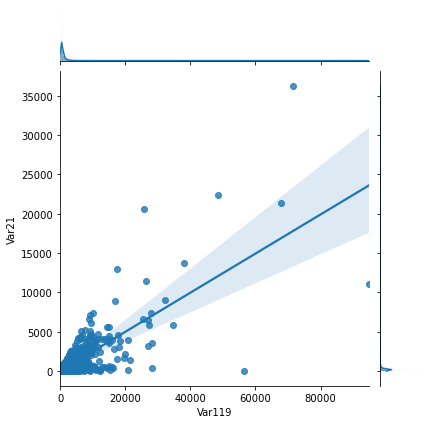

In [21]:
sns.jointplot(x="Var119", y="Var21", data=data, kind='reg')

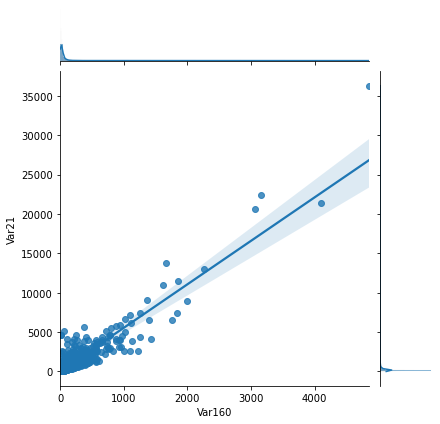

In [22]:
sns.jointplot(x="Var160", y="Var21", data=data, kind='reg')

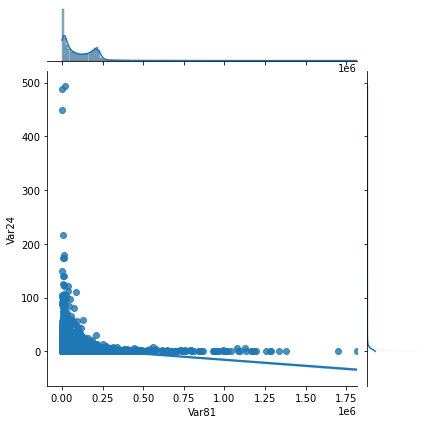

In [23]:
sns.jointplot(x="Var81", y="Var24", data=data, kind='reg')

In [51]:
data_top_corr = []
for i in range(len(corr_map.columns)-1):
    cur_name = corr_map.columns[i]
    other_columns = corr_map.columns[corr_map.columns != cur_name]
    data_top_corr.append([cur_name, corr_map.loc[corr_map.index == cur_name, other_columns].idxmax(axis=1).to_numpy()[0]])

In [53]:
data_top_corr[:5]

[['Var6', 'Var119'],
 ['Var7', 'Var140'],
 ['Var13', 'Var140'],
 ['Var21', 'Var22'],
 ['Var22', 'Var21']]

<Figure size 432x288 with 0 Axes>

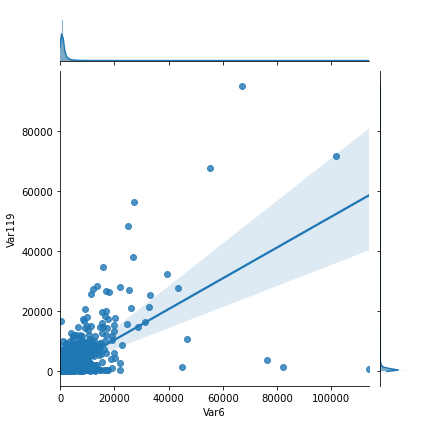

<Figure size 432x288 with 0 Axes>

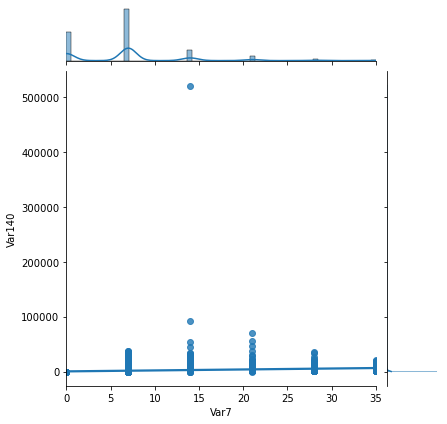

<Figure size 432x288 with 0 Axes>

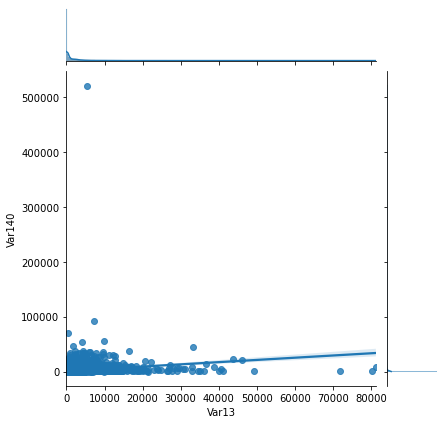

<Figure size 432x288 with 0 Axes>

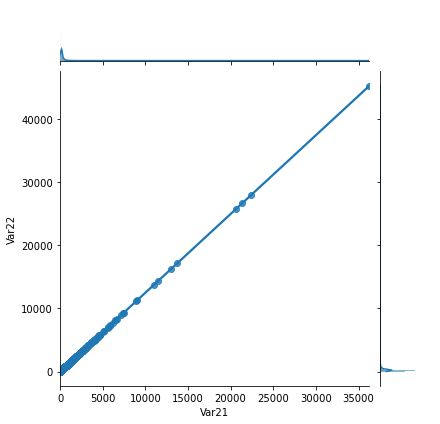

<Figure size 432x288 with 0 Axes>

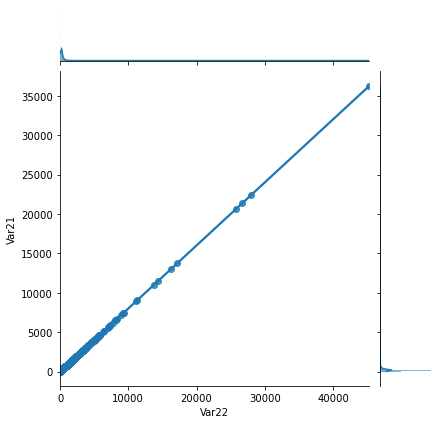

<Figure size 432x288 with 0 Axes>

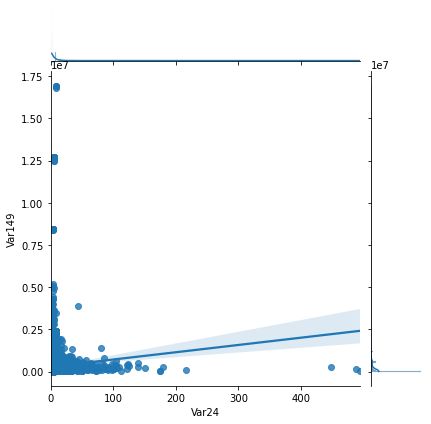

<Figure size 432x288 with 0 Axes>

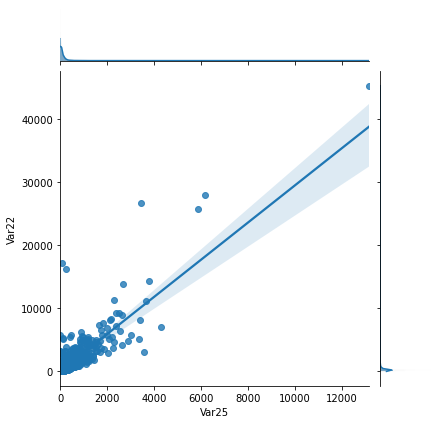

<Figure size 432x288 with 0 Axes>

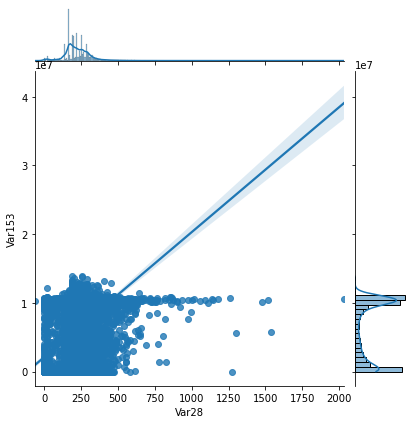

<Figure size 432x288 with 0 Axes>

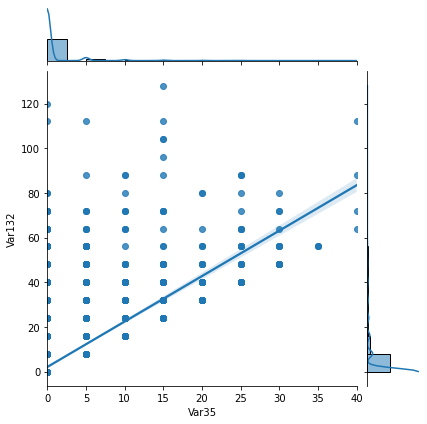

<Figure size 432x288 with 0 Axes>

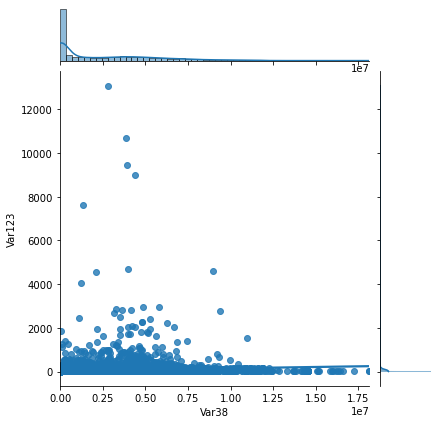

<Figure size 432x288 with 0 Axes>

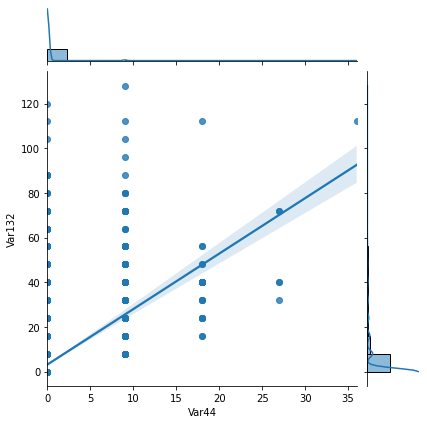

<Figure size 432x288 with 0 Axes>

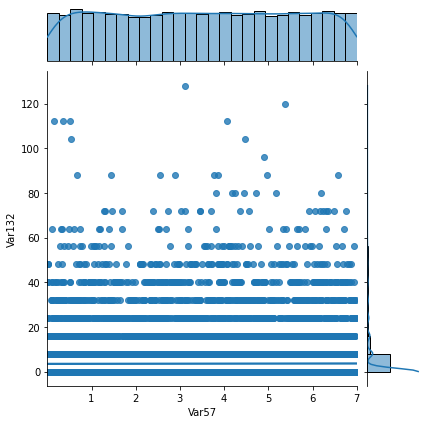

<Figure size 432x288 with 0 Axes>

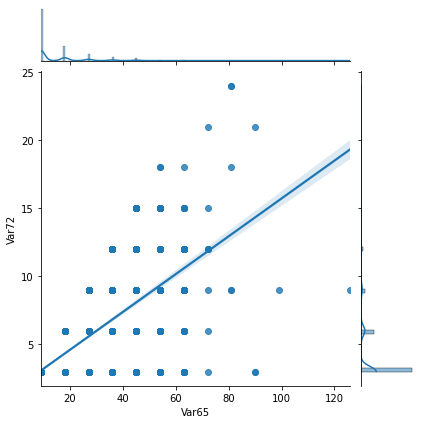

<Figure size 432x288 with 0 Axes>

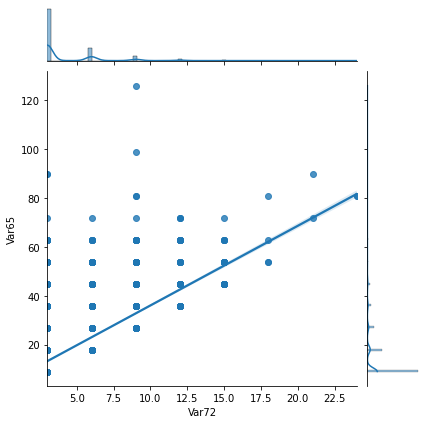

<Figure size 432x288 with 0 Axes>

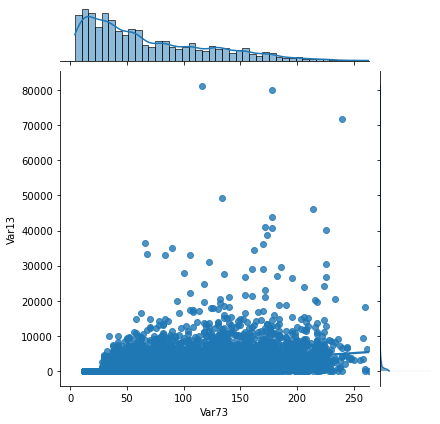

<Figure size 432x288 with 0 Axes>

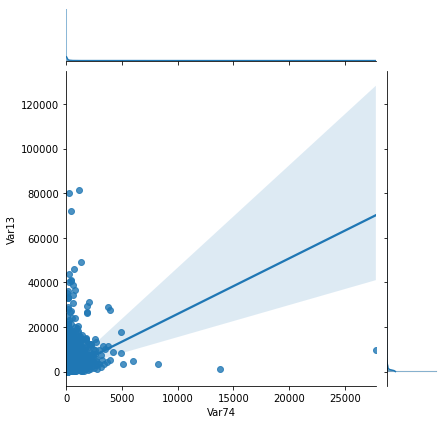

<Figure size 432x288 with 0 Axes>

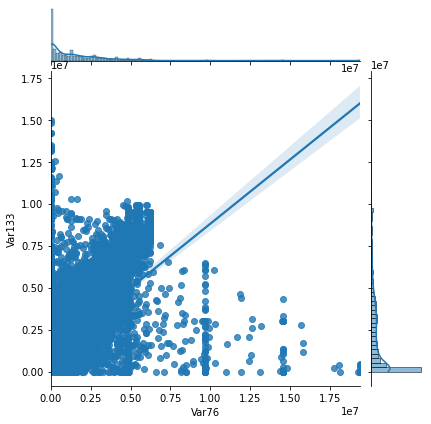

<Figure size 432x288 with 0 Axes>

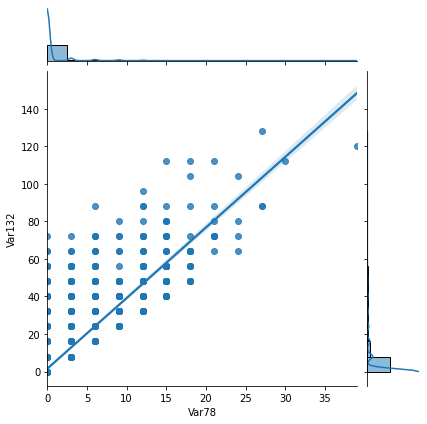

<Figure size 432x288 with 0 Axes>

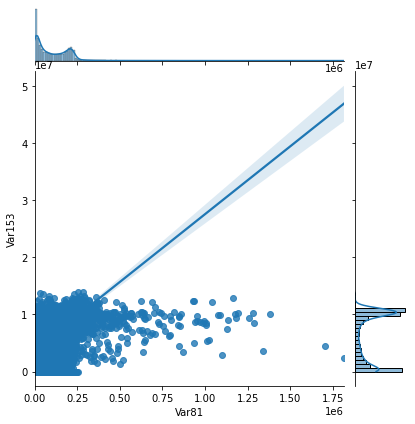

<Figure size 432x288 with 0 Axes>

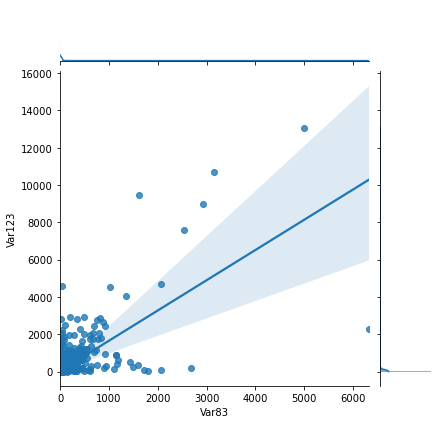

<Figure size 432x288 with 0 Axes>

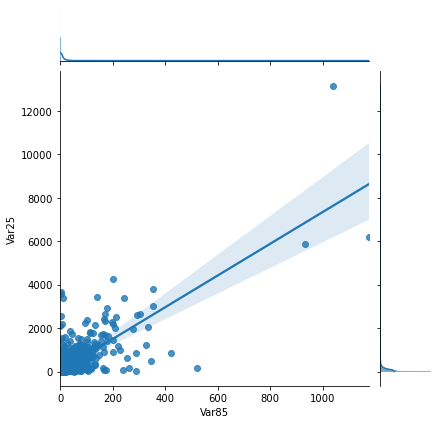

<Figure size 432x288 with 0 Axes>

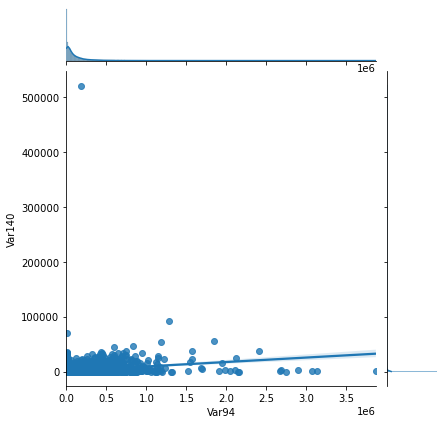

<Figure size 432x288 with 0 Axes>

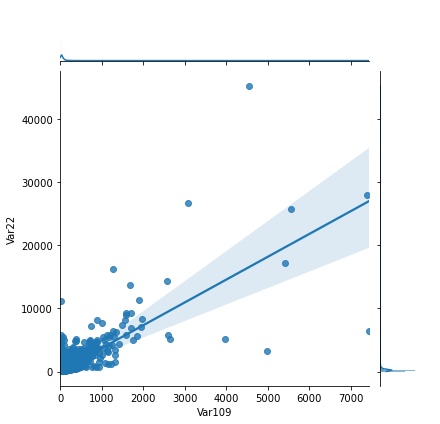

<Figure size 432x288 with 0 Axes>

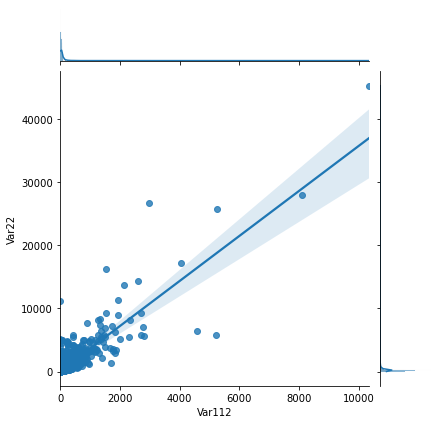

<Figure size 432x288 with 0 Axes>

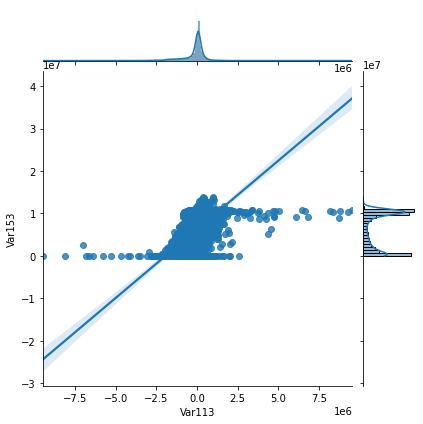

<Figure size 432x288 with 0 Axes>

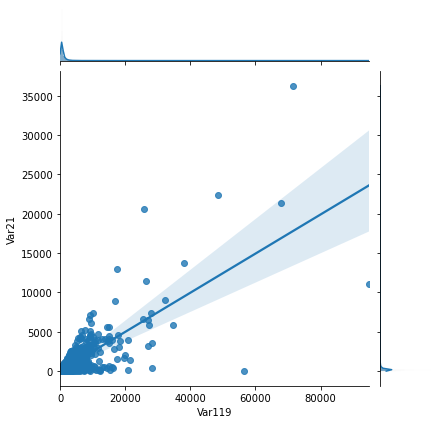

<Figure size 432x288 with 0 Axes>

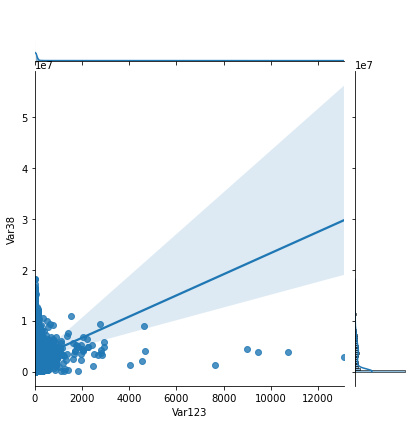

<Figure size 432x288 with 0 Axes>

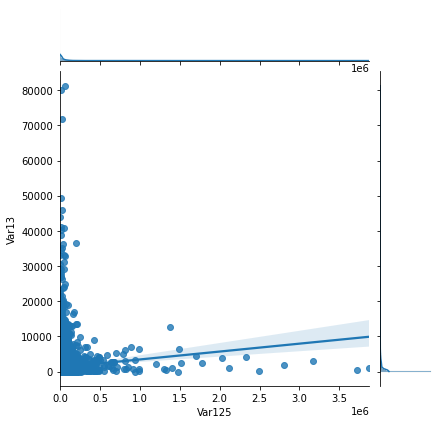

<Figure size 432x288 with 0 Axes>

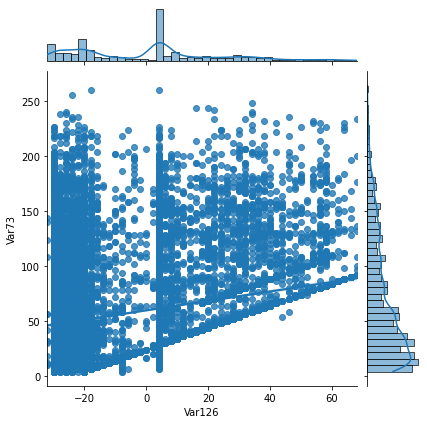

<Figure size 432x288 with 0 Axes>

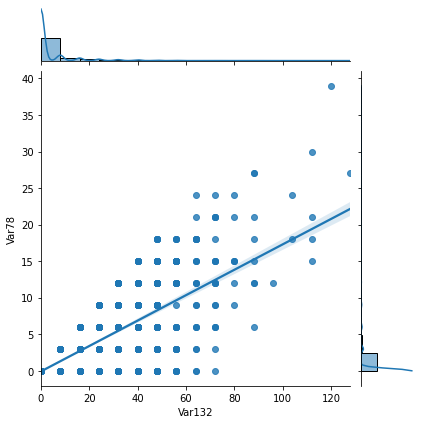

<Figure size 432x288 with 0 Axes>

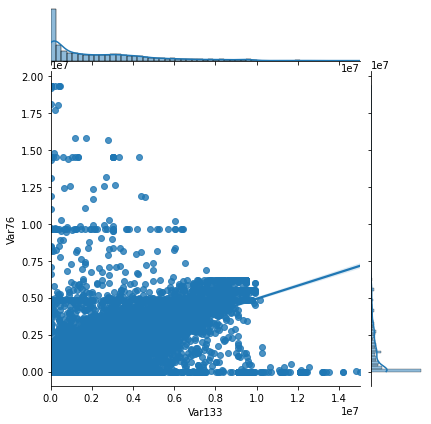

<Figure size 432x288 with 0 Axes>

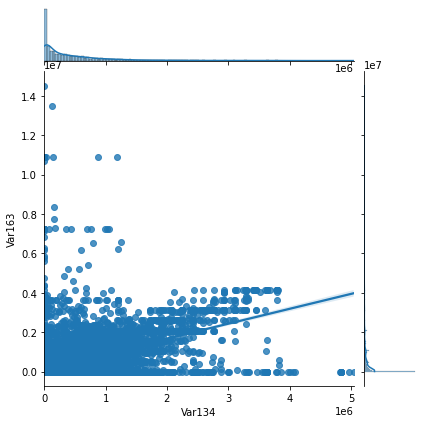

<Figure size 432x288 with 0 Axes>

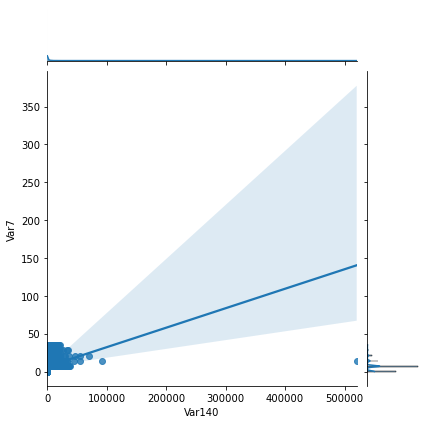

<Figure size 432x288 with 0 Axes>

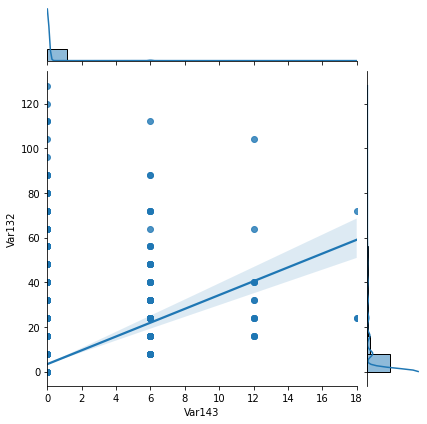

<Figure size 432x288 with 0 Axes>

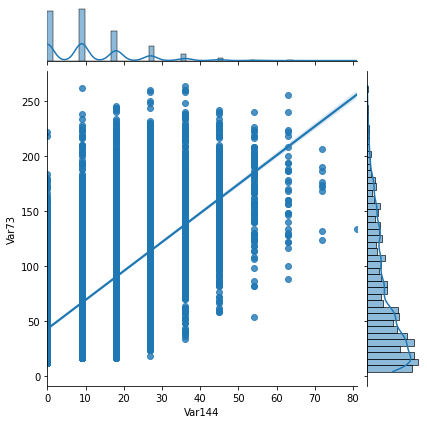

<Figure size 432x288 with 0 Axes>

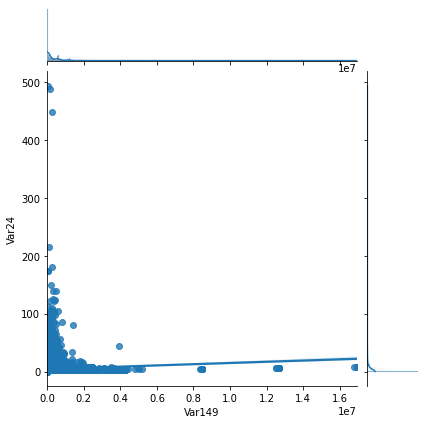

<Figure size 432x288 with 0 Axes>

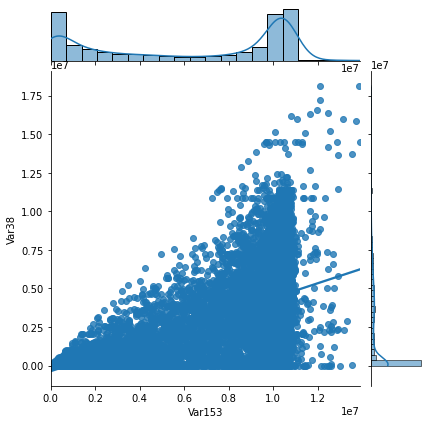

<Figure size 432x288 with 0 Axes>

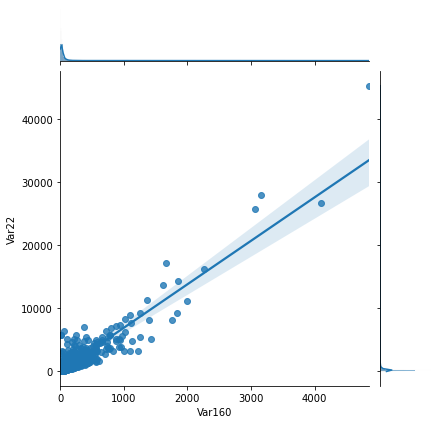

<Figure size 432x288 with 0 Axes>

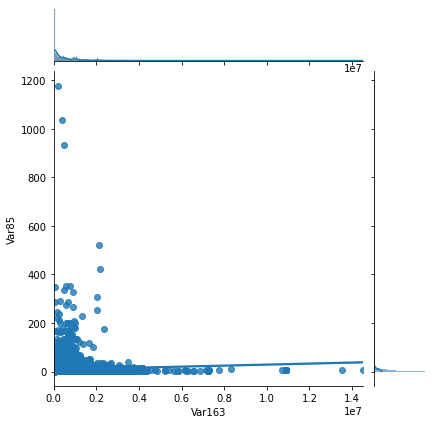

<Figure size 432x288 with 0 Axes>

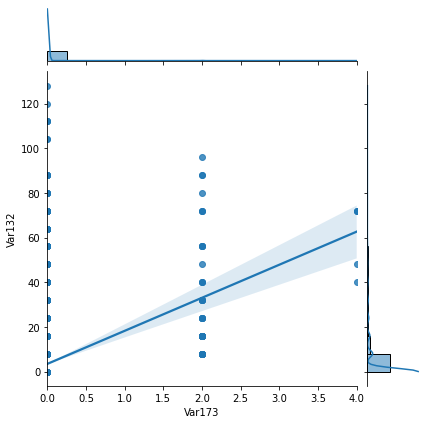

In [54]:
for n_1, n_2 in data_top_corr:
    plt.figure()
    sns.jointplot(x=n_1, y=n_2, data=data, kind='reg')
    plt.show()

In [57]:
data['Var21'].describe()

count    16307.000000
mean       235.956338
std        580.036843
min          0.000000
25%        112.000000
50%        144.000000
75%        232.000000
max      36272.000000
Name: Var21, dtype: float64

<AxesSubplot:>

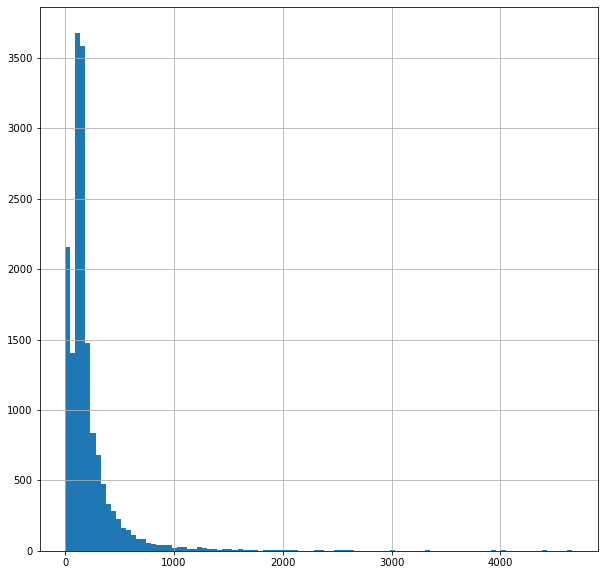

In [61]:
data[data['Var21'] < 5000]['Var21'].hist(bins=100, figsize=(10,10))

Drop numeric feature for corr each other: 21, 22, 25, 160, 109, 112. drop feature from list except 21

In [67]:
right_columns_numeric_1 = right_numeric_column[~right_numeric_column.isin(['Var22', 'Var25','Var160','Var109',
                                                                          'Var112'])]

In [21]:
# cat feature

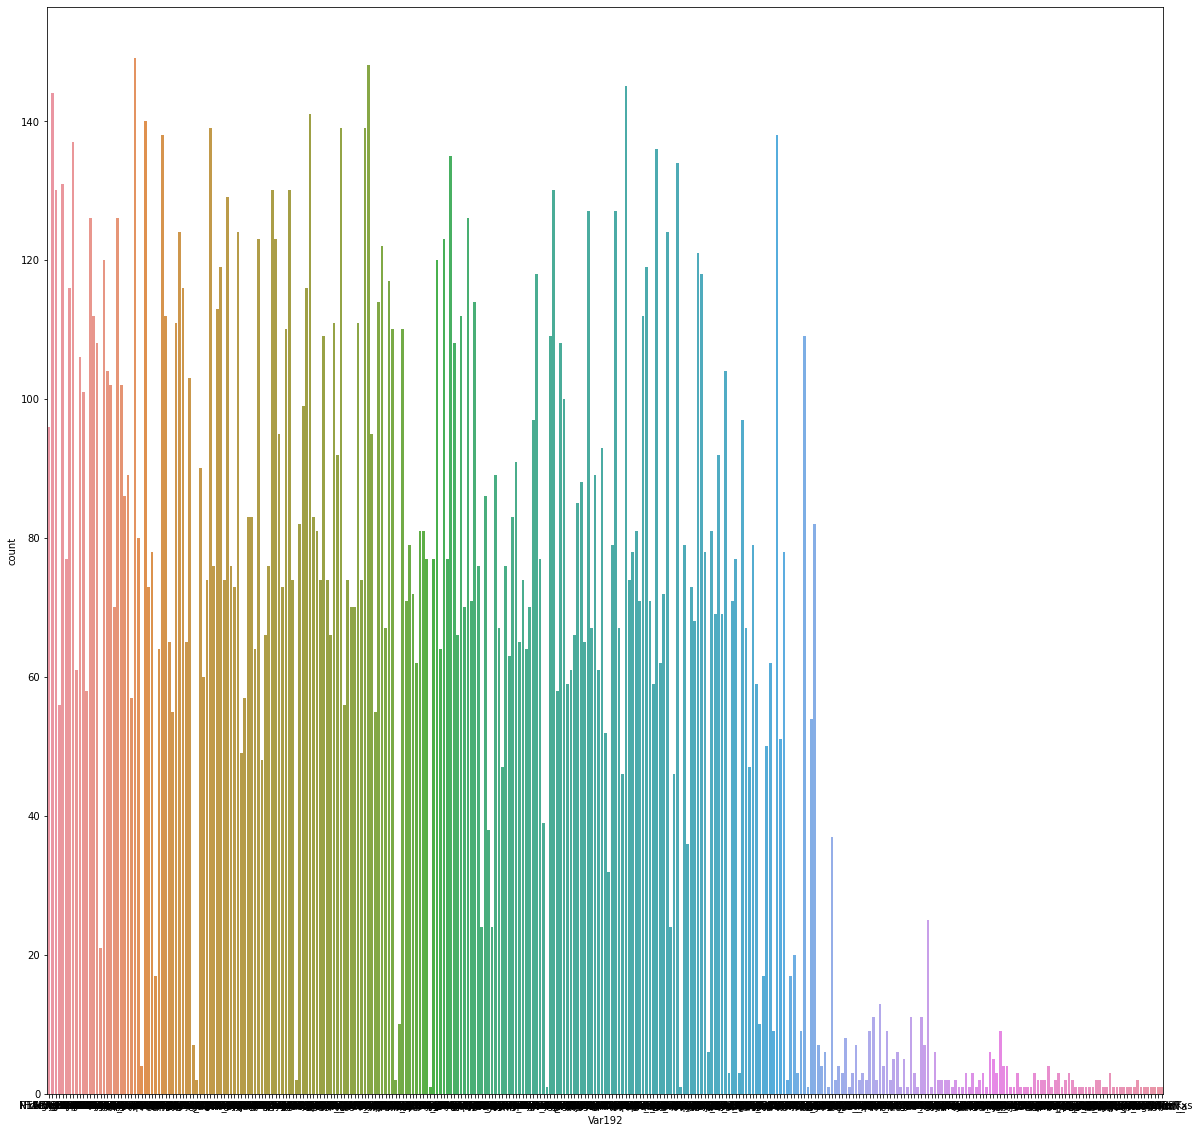

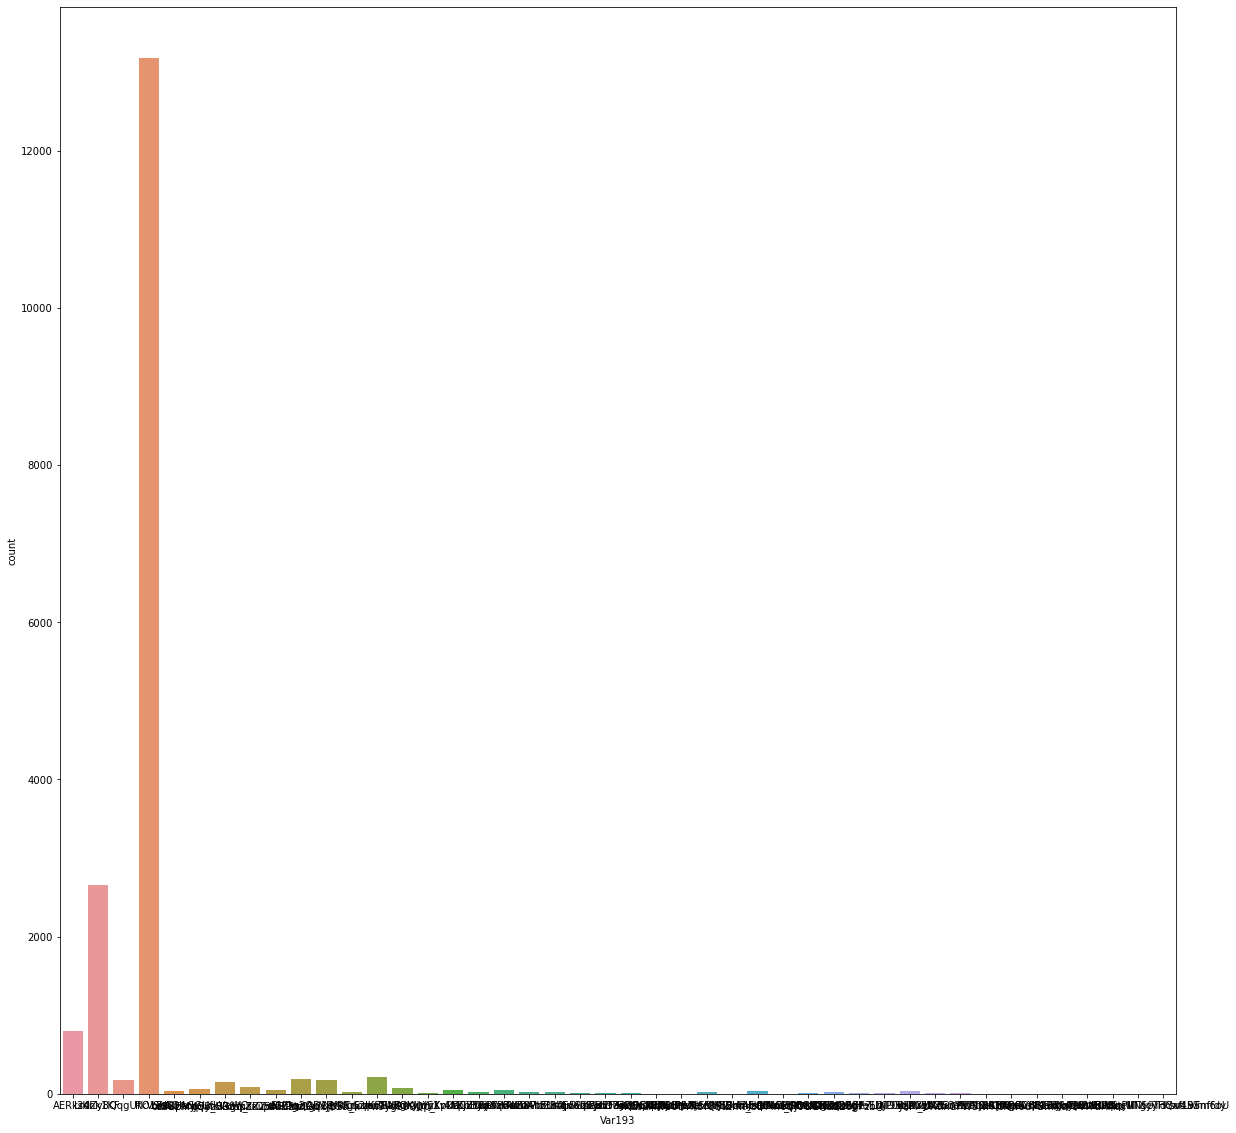

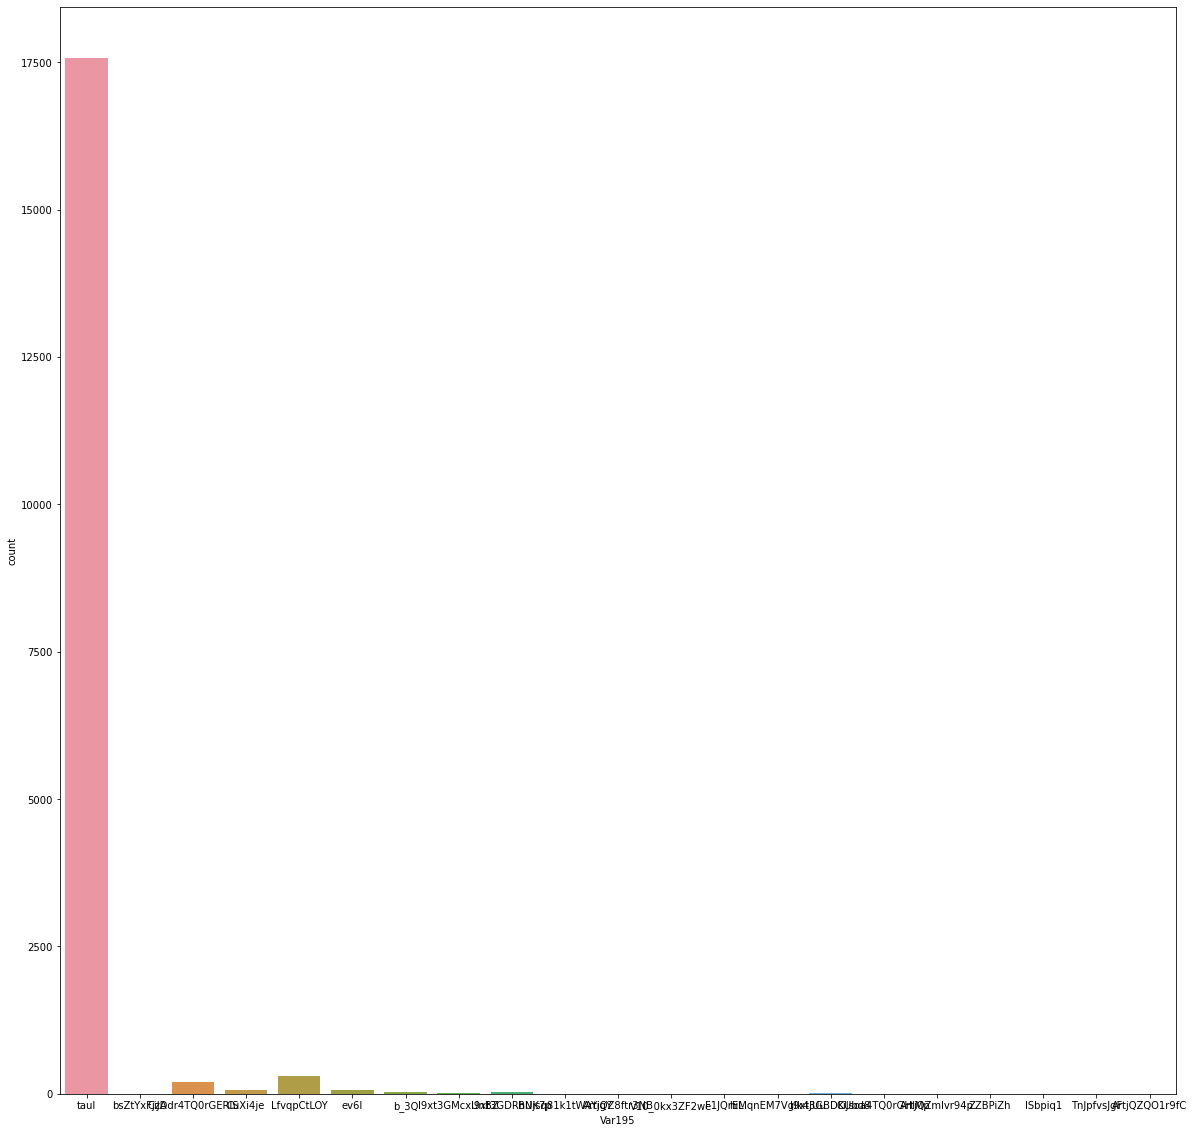

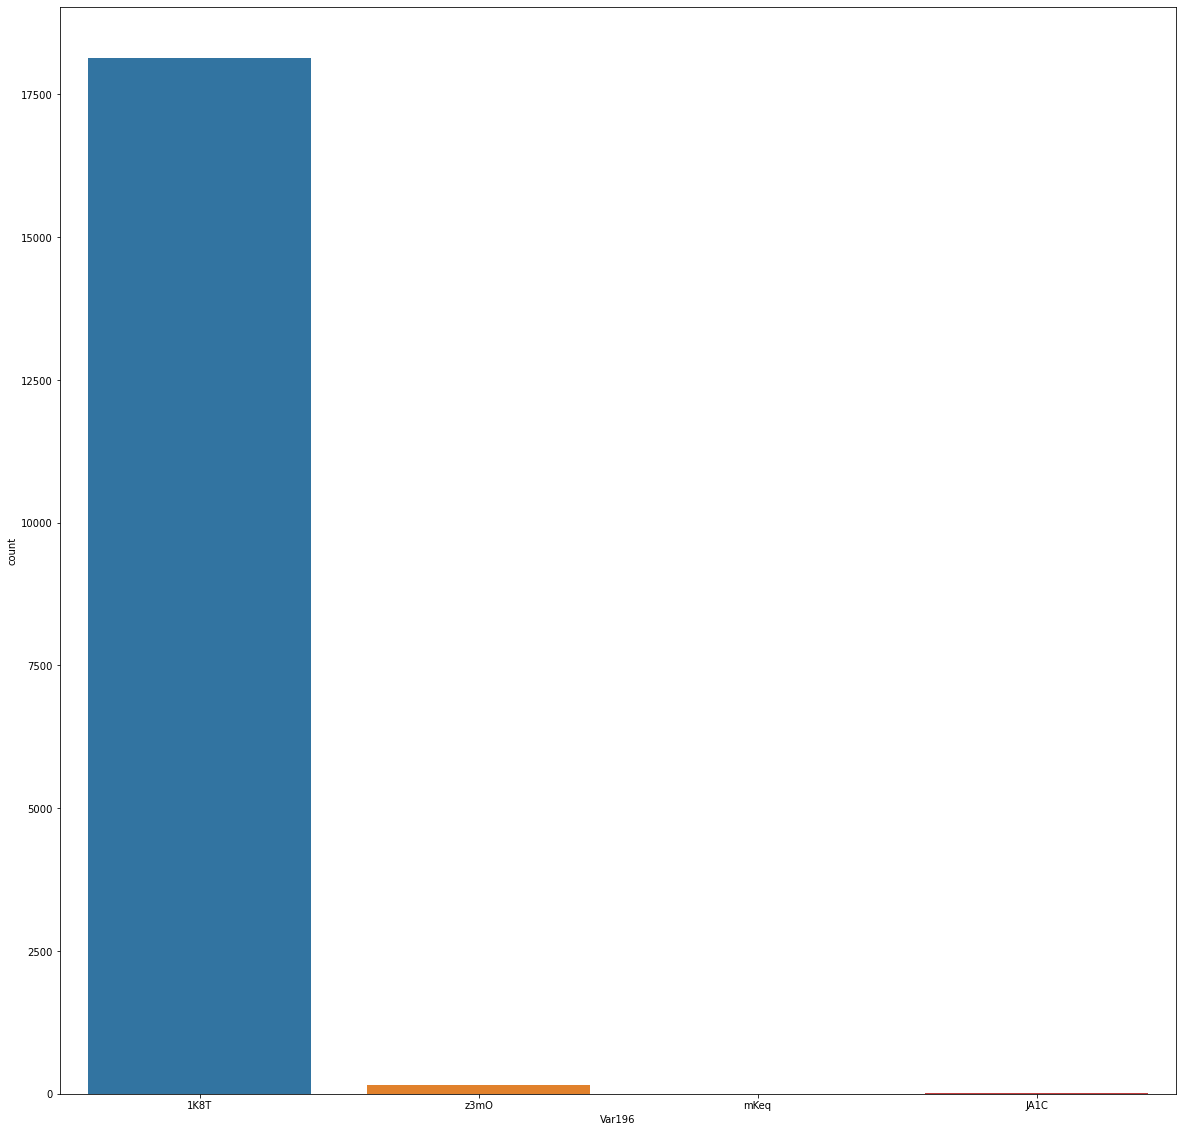

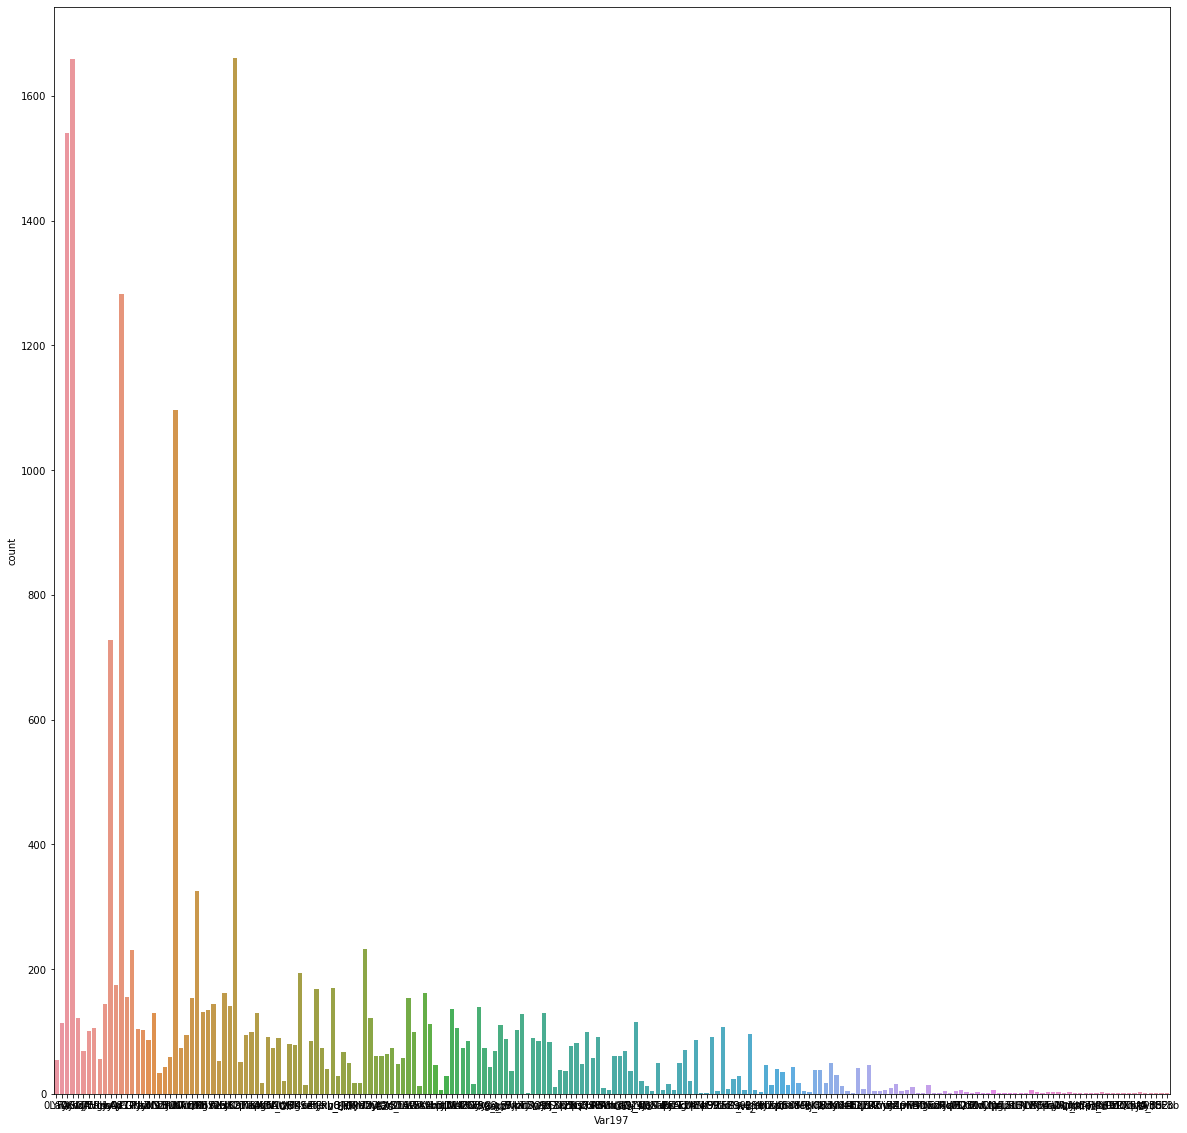

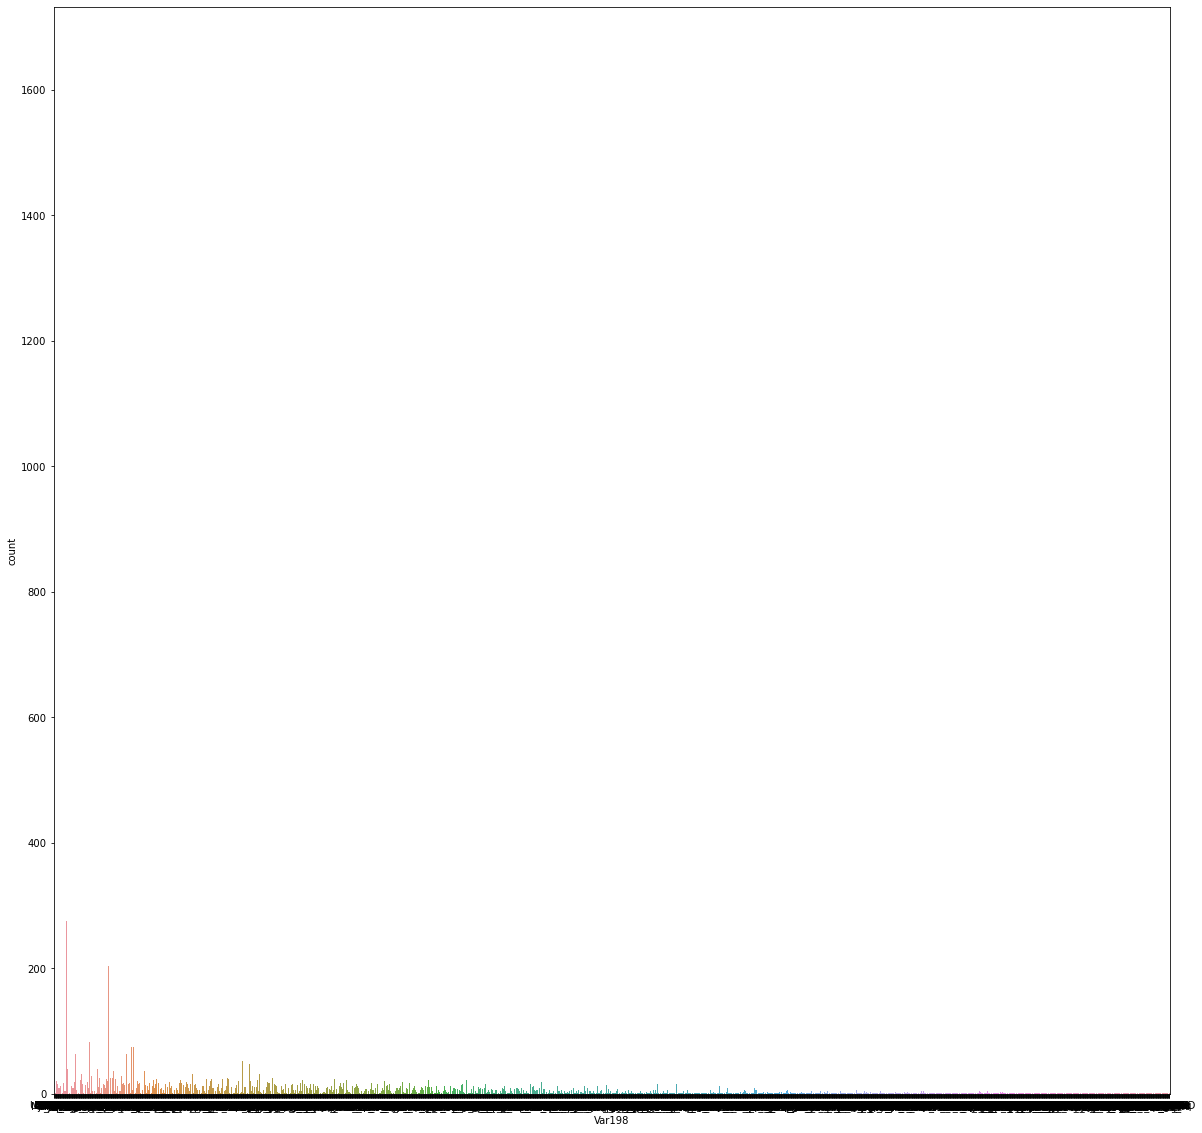

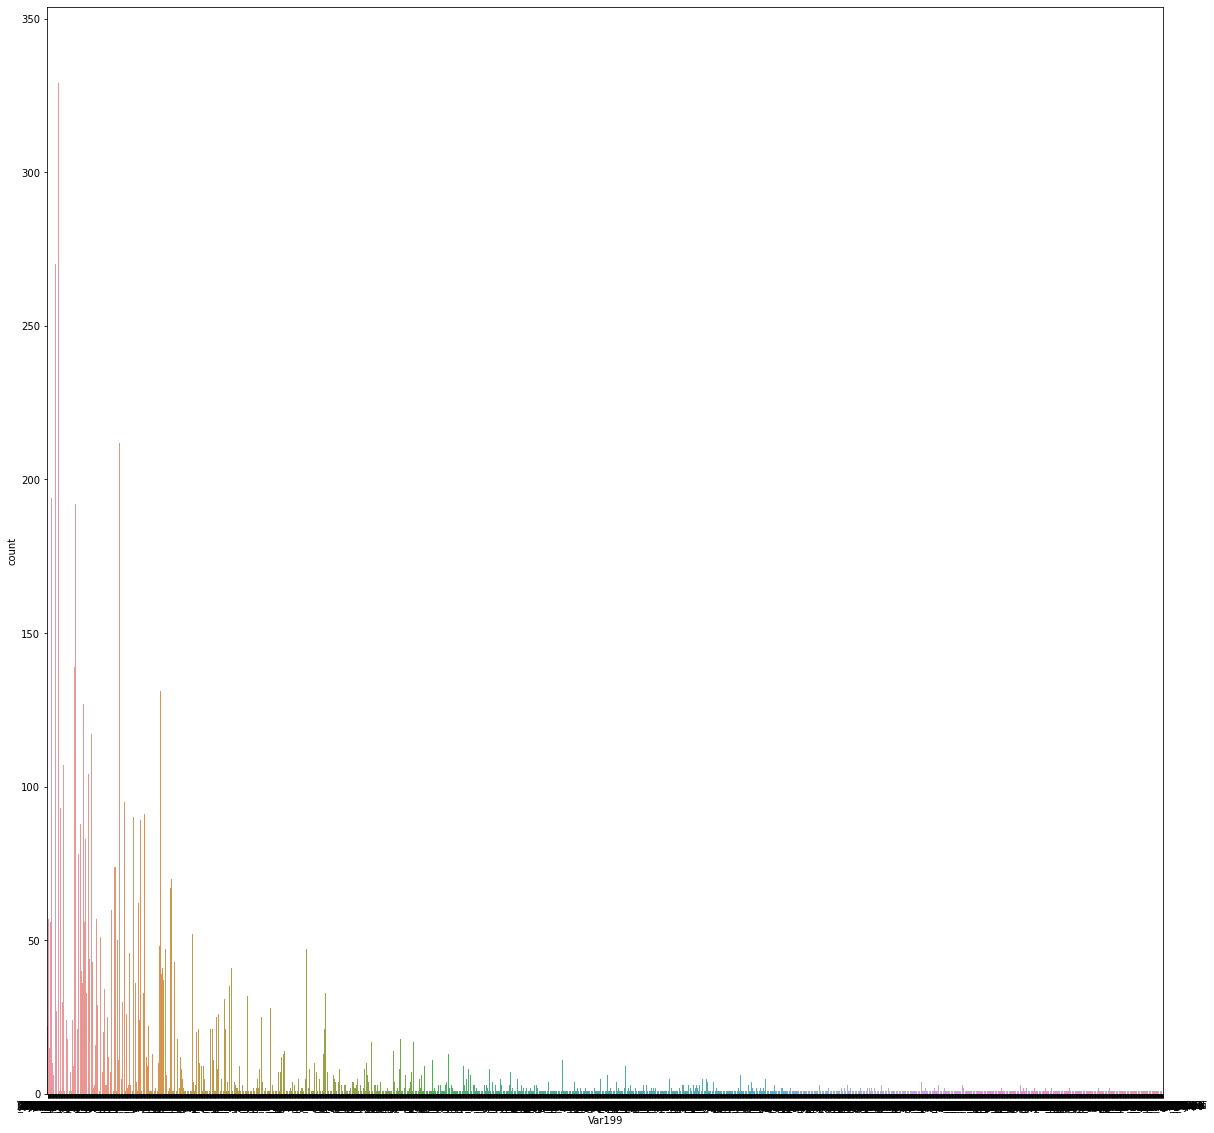

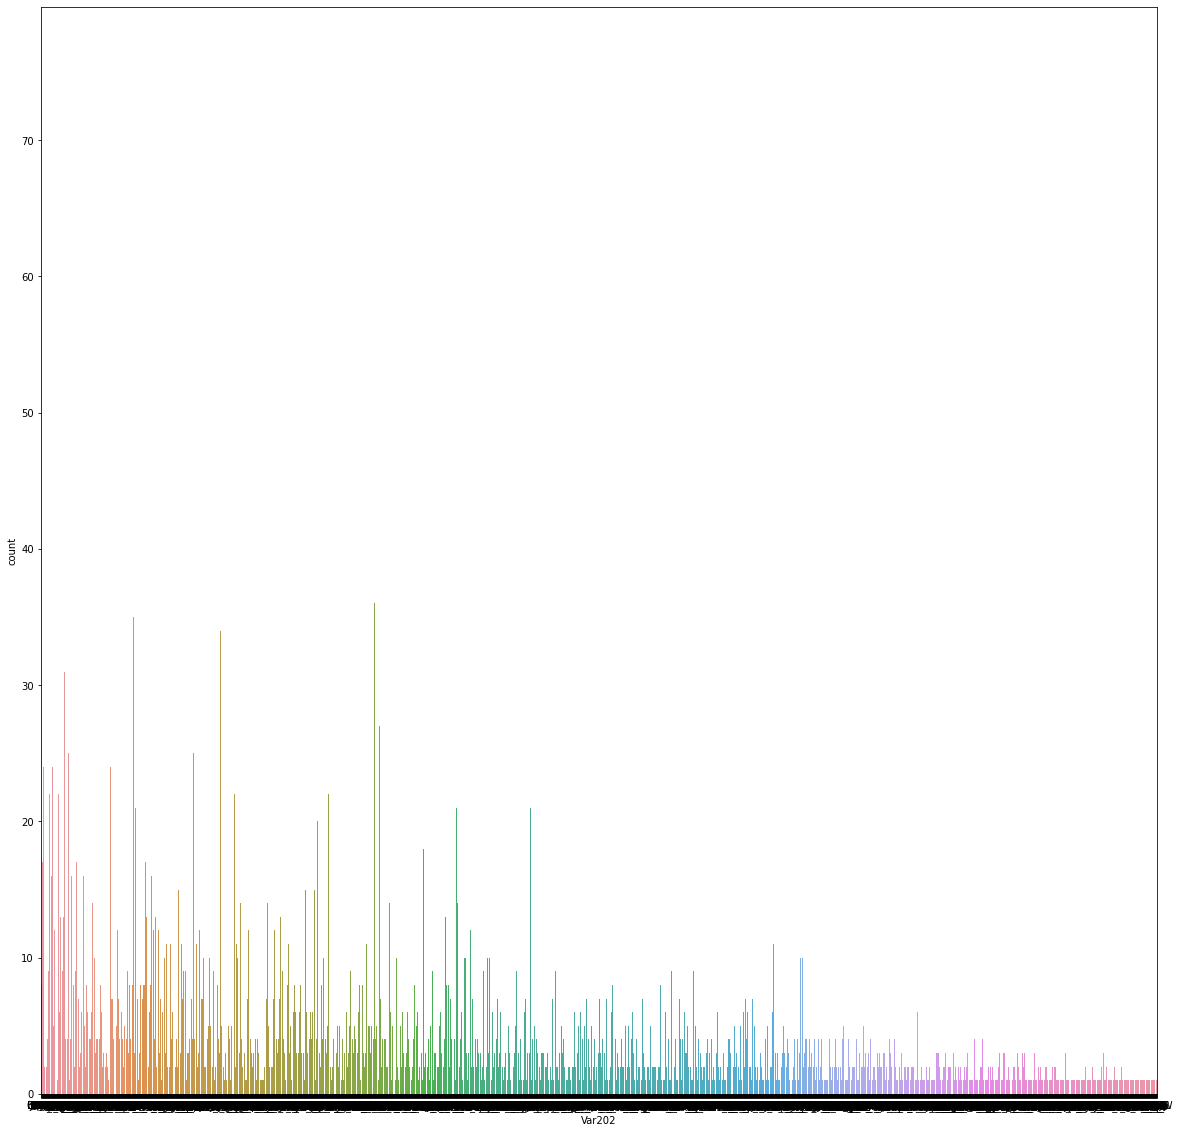

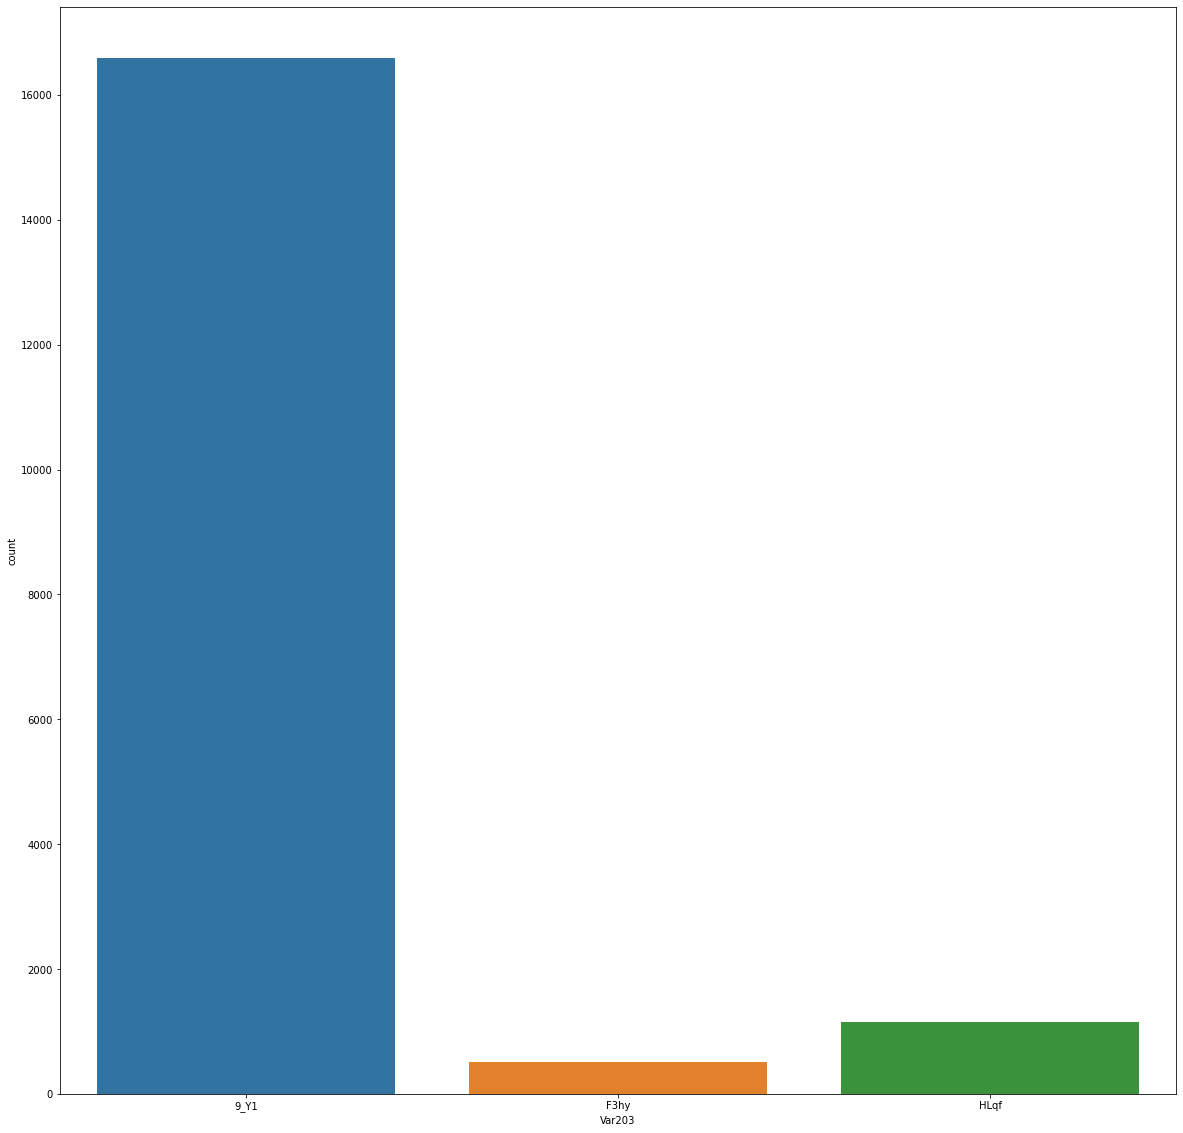

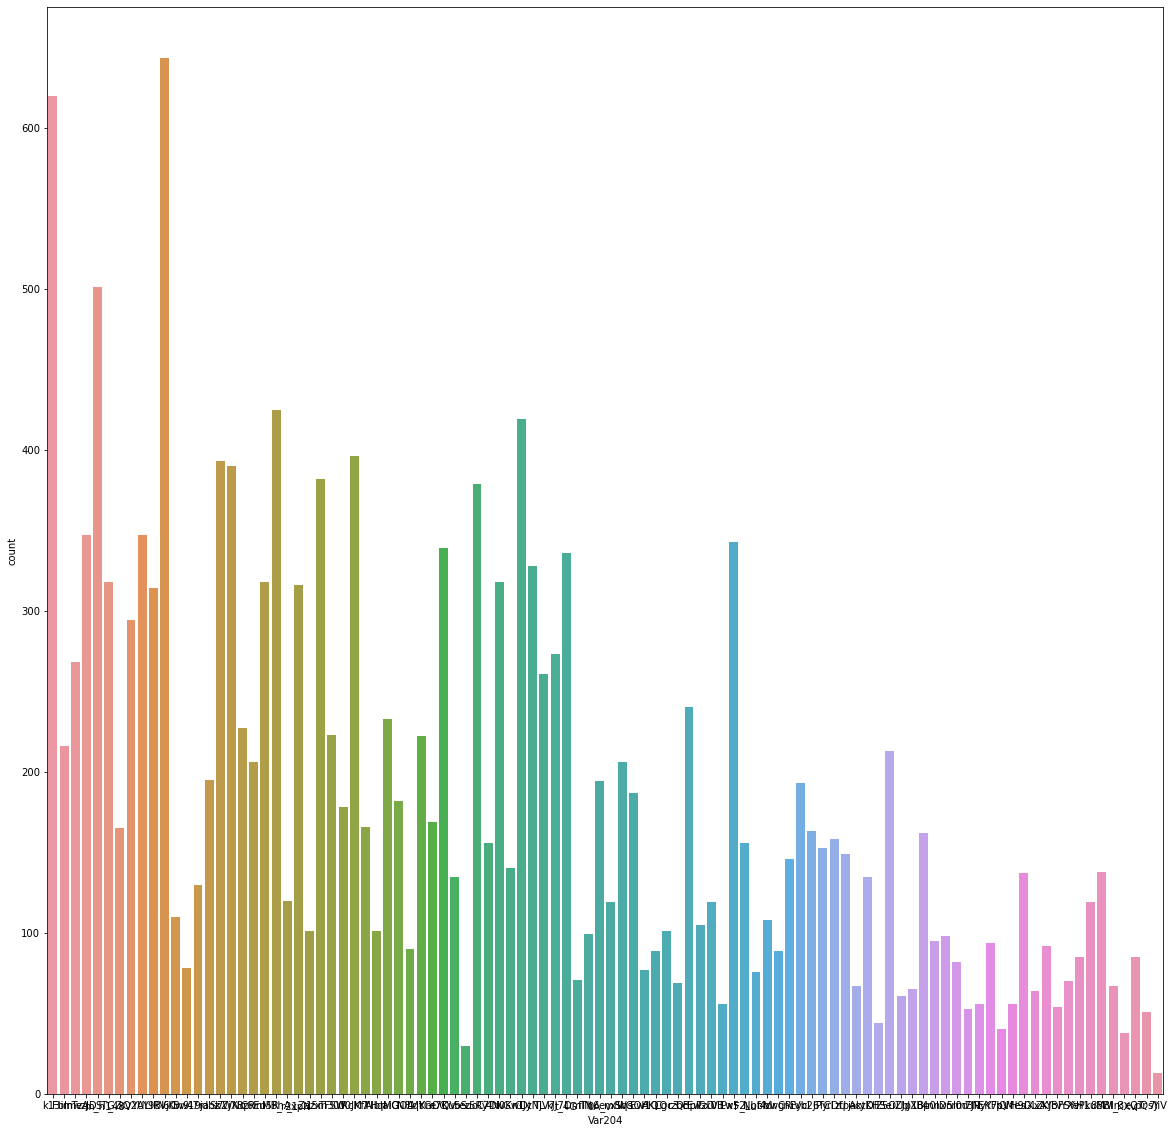

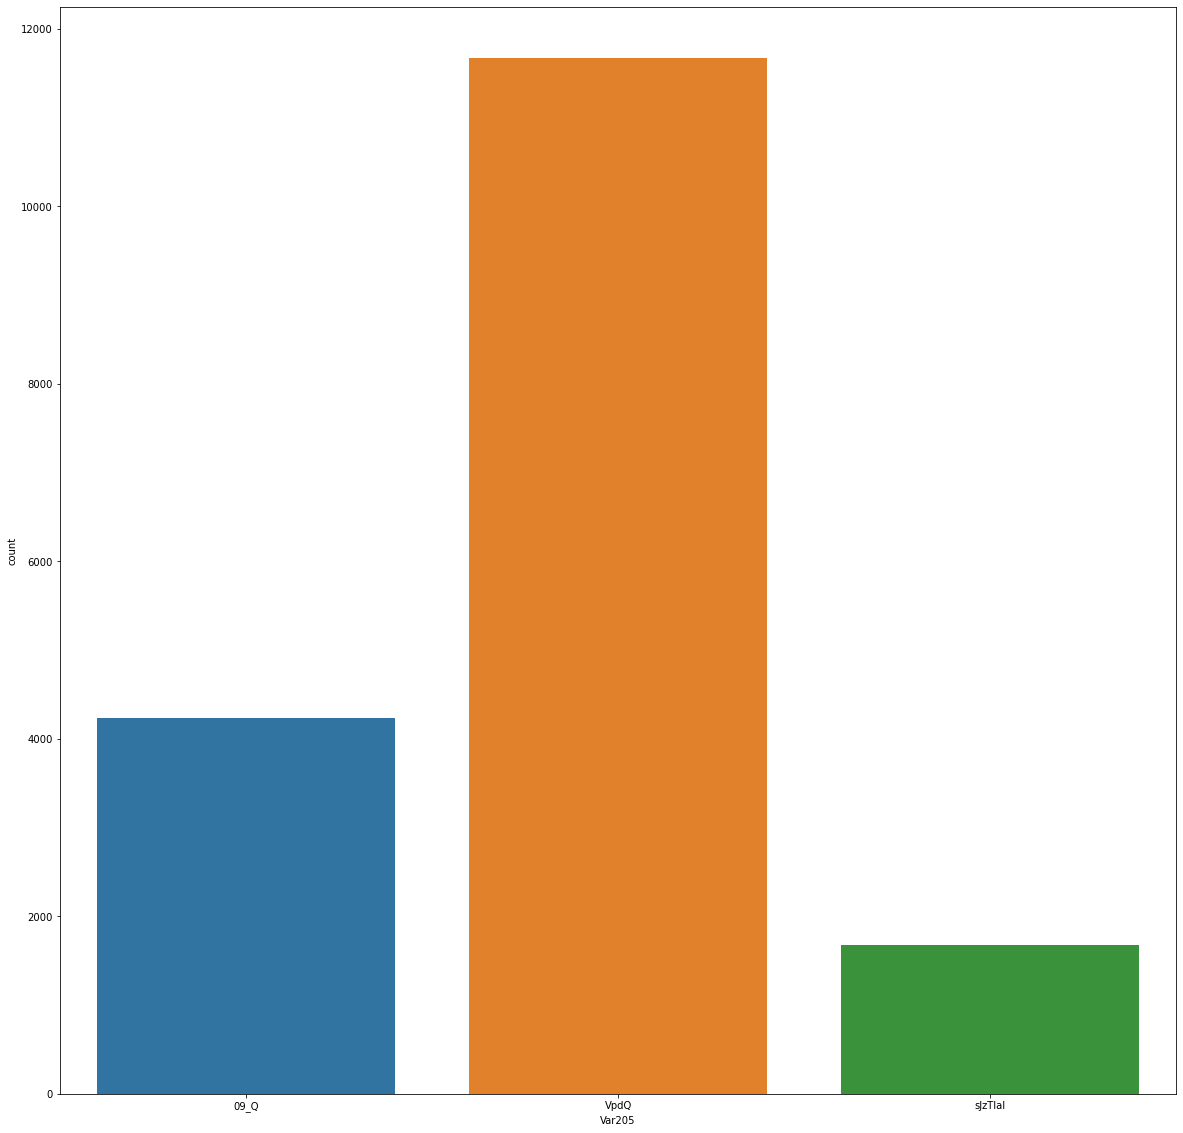

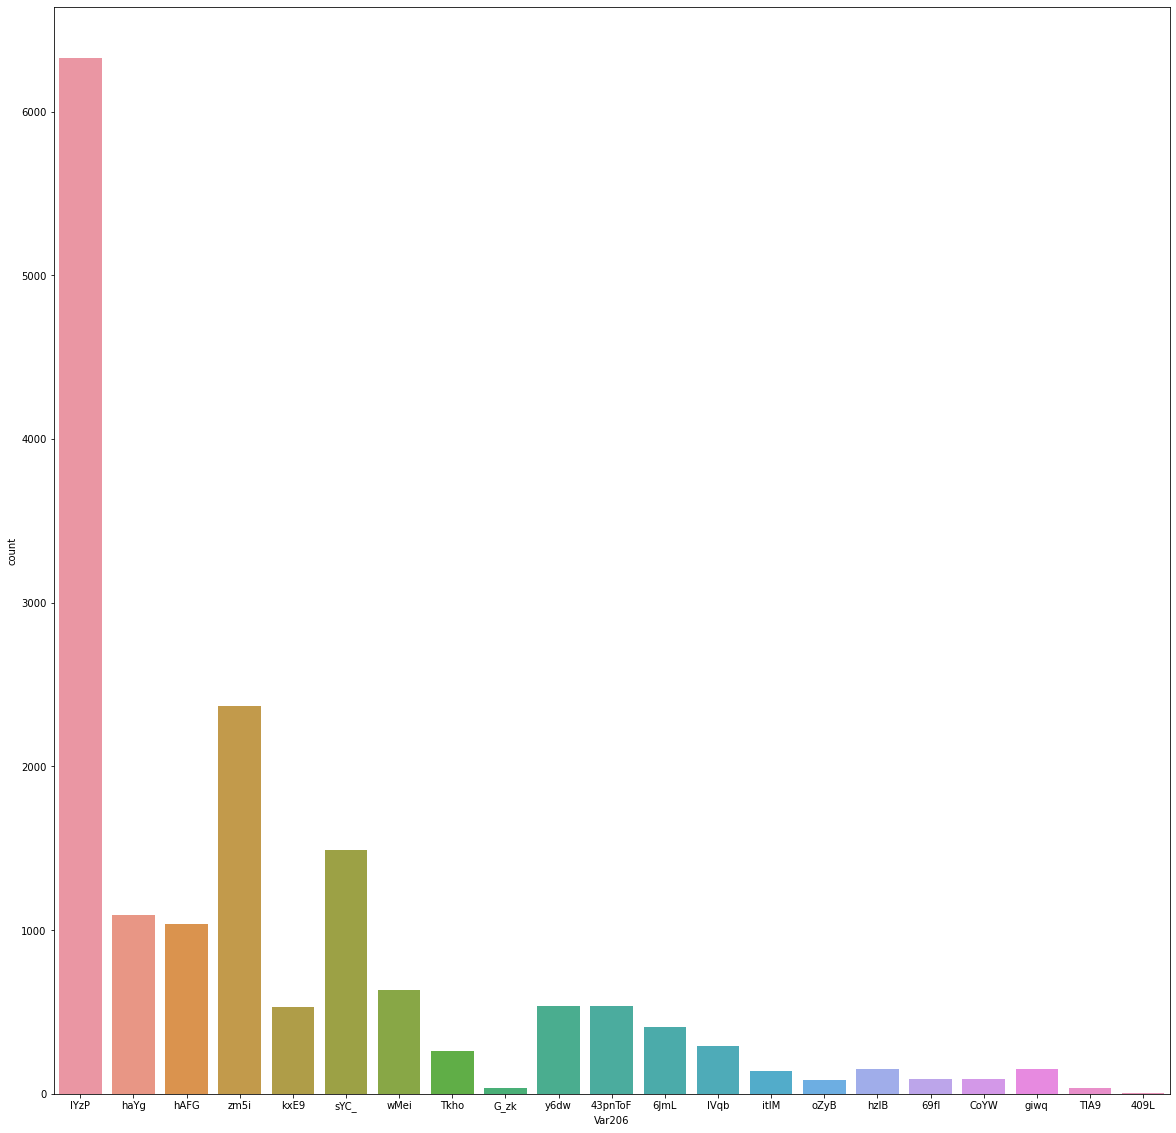

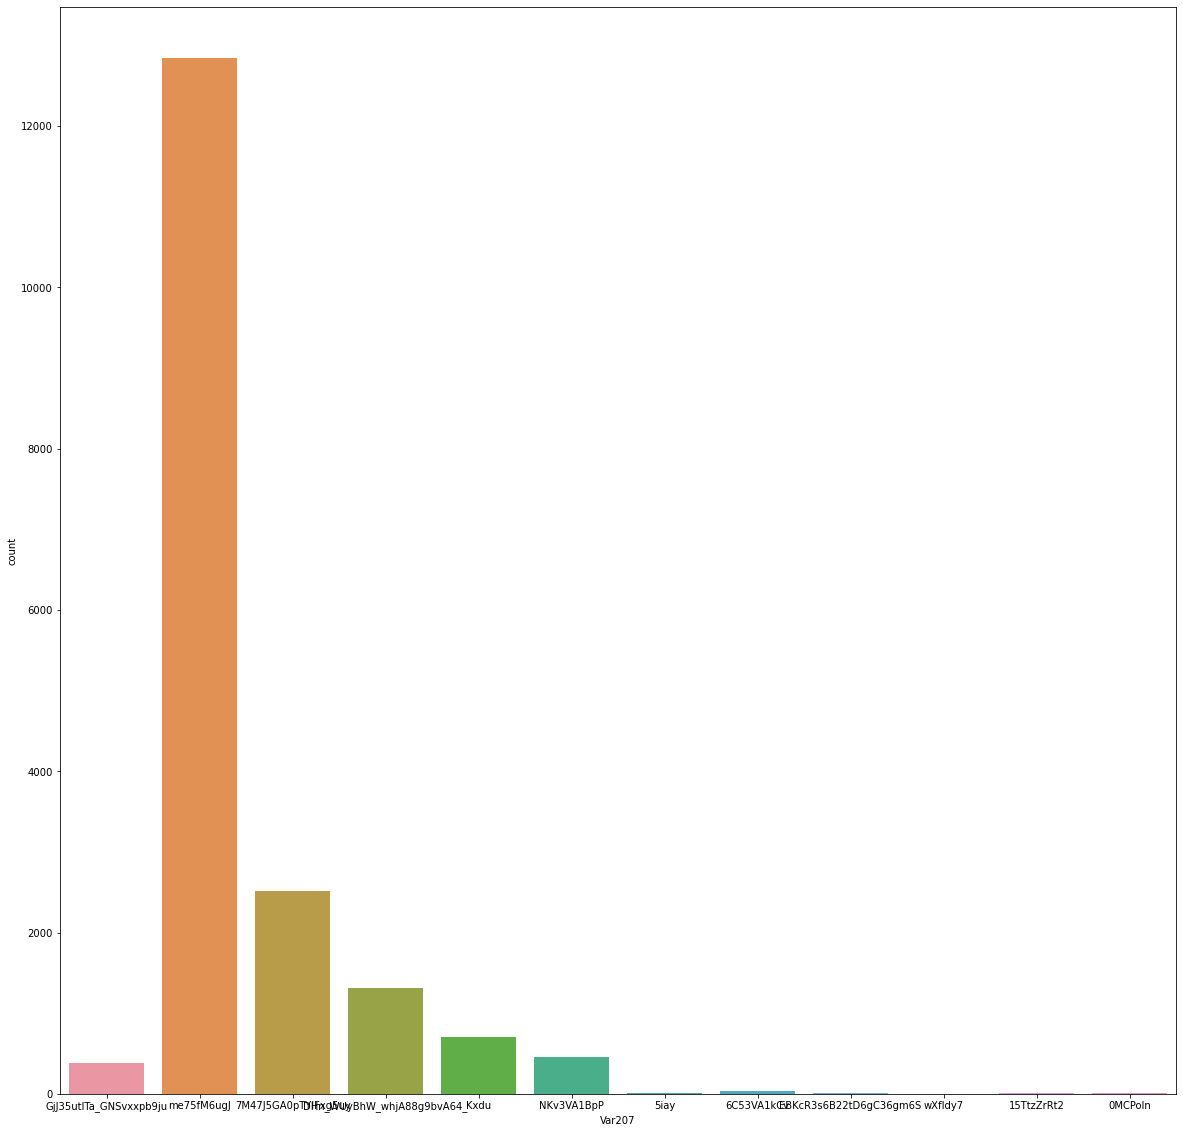

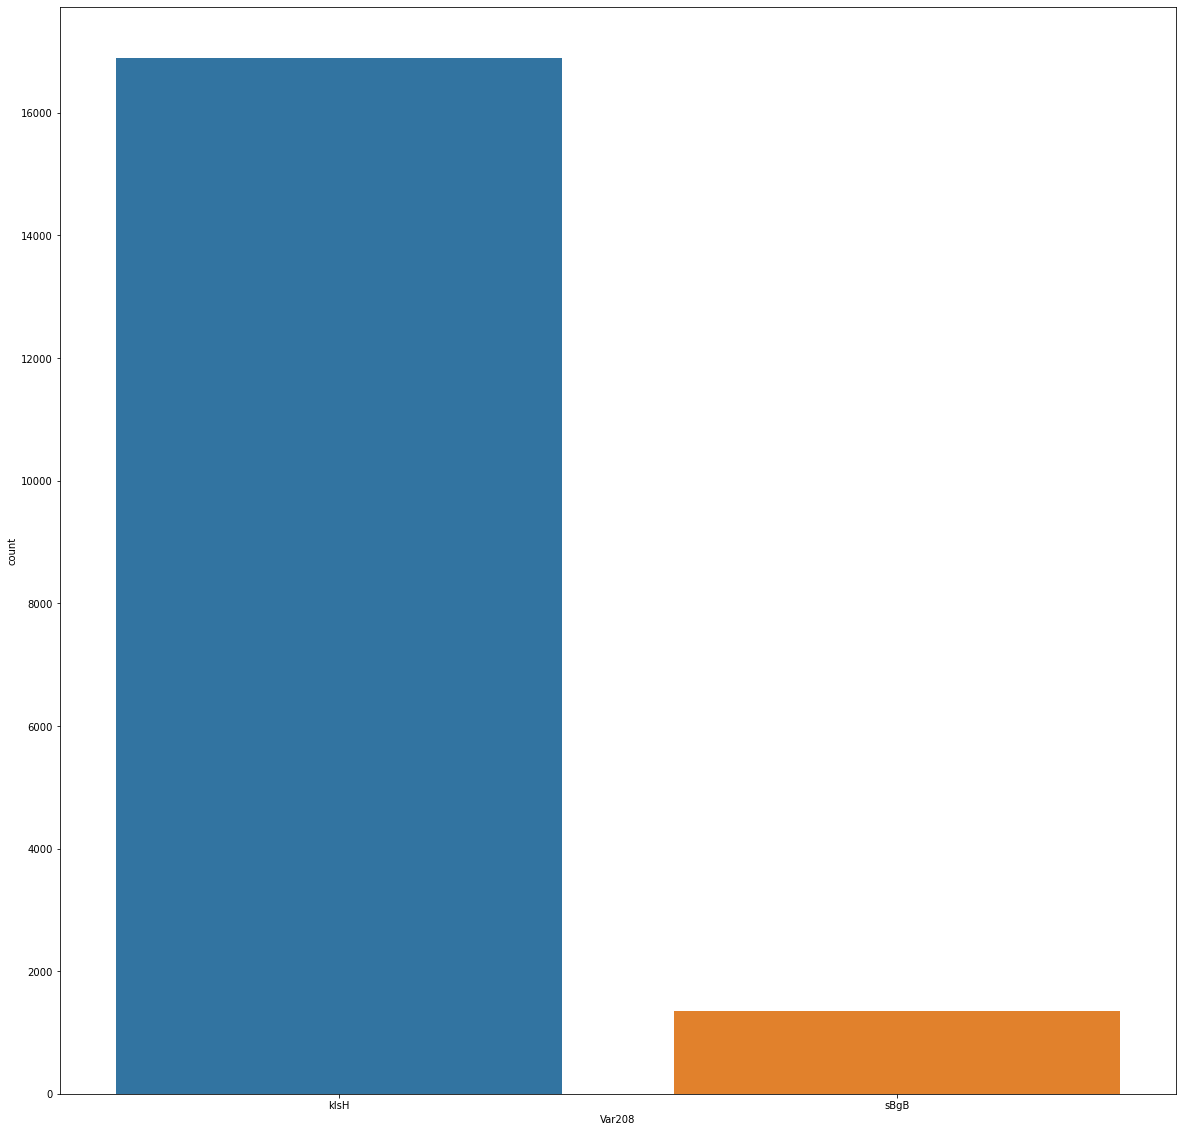

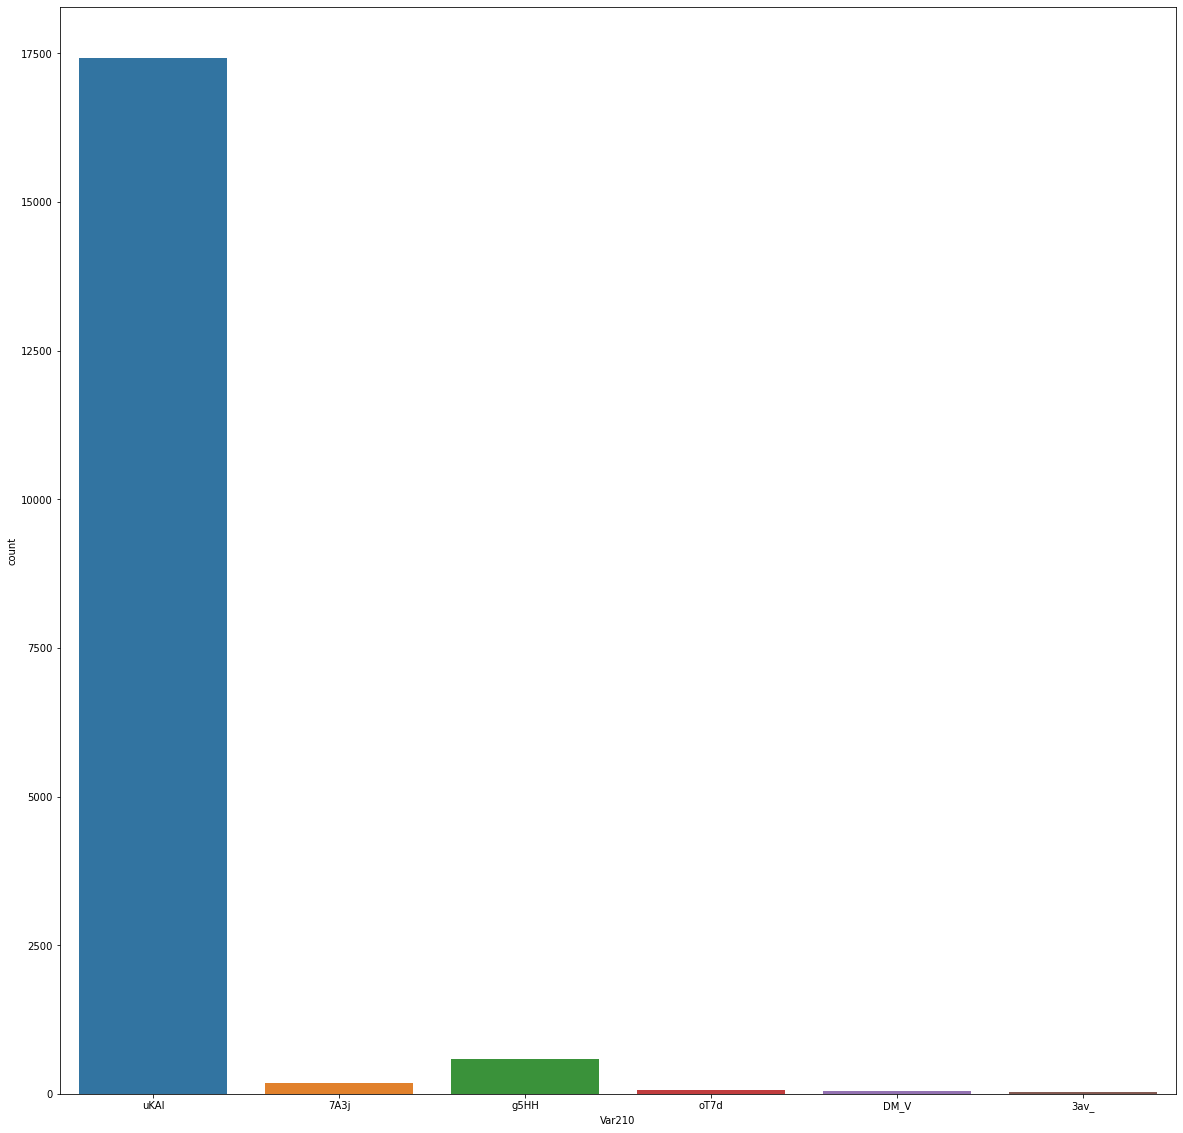

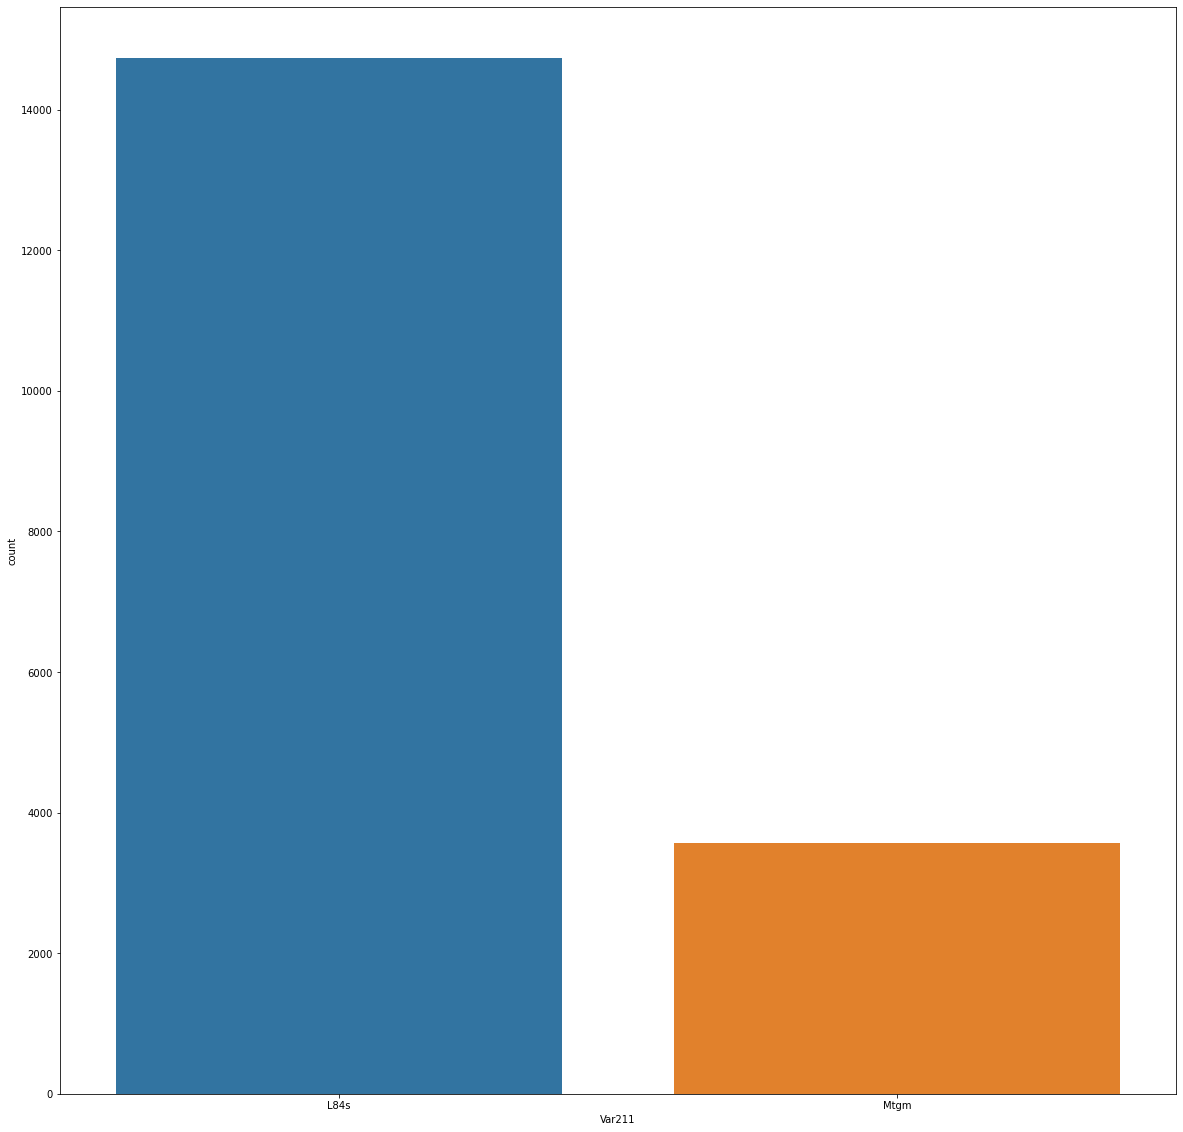

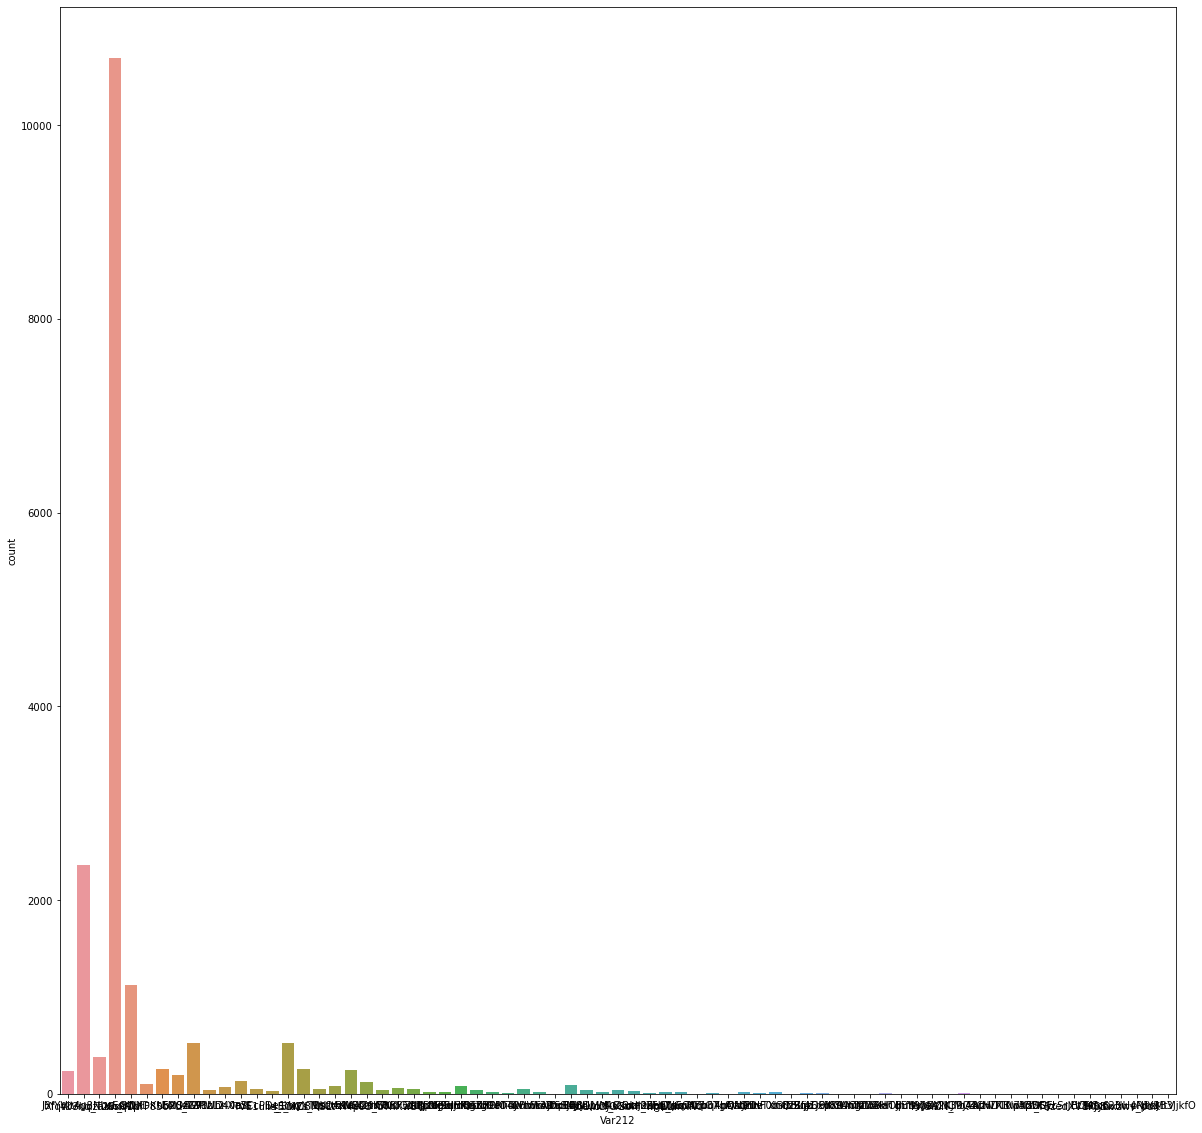

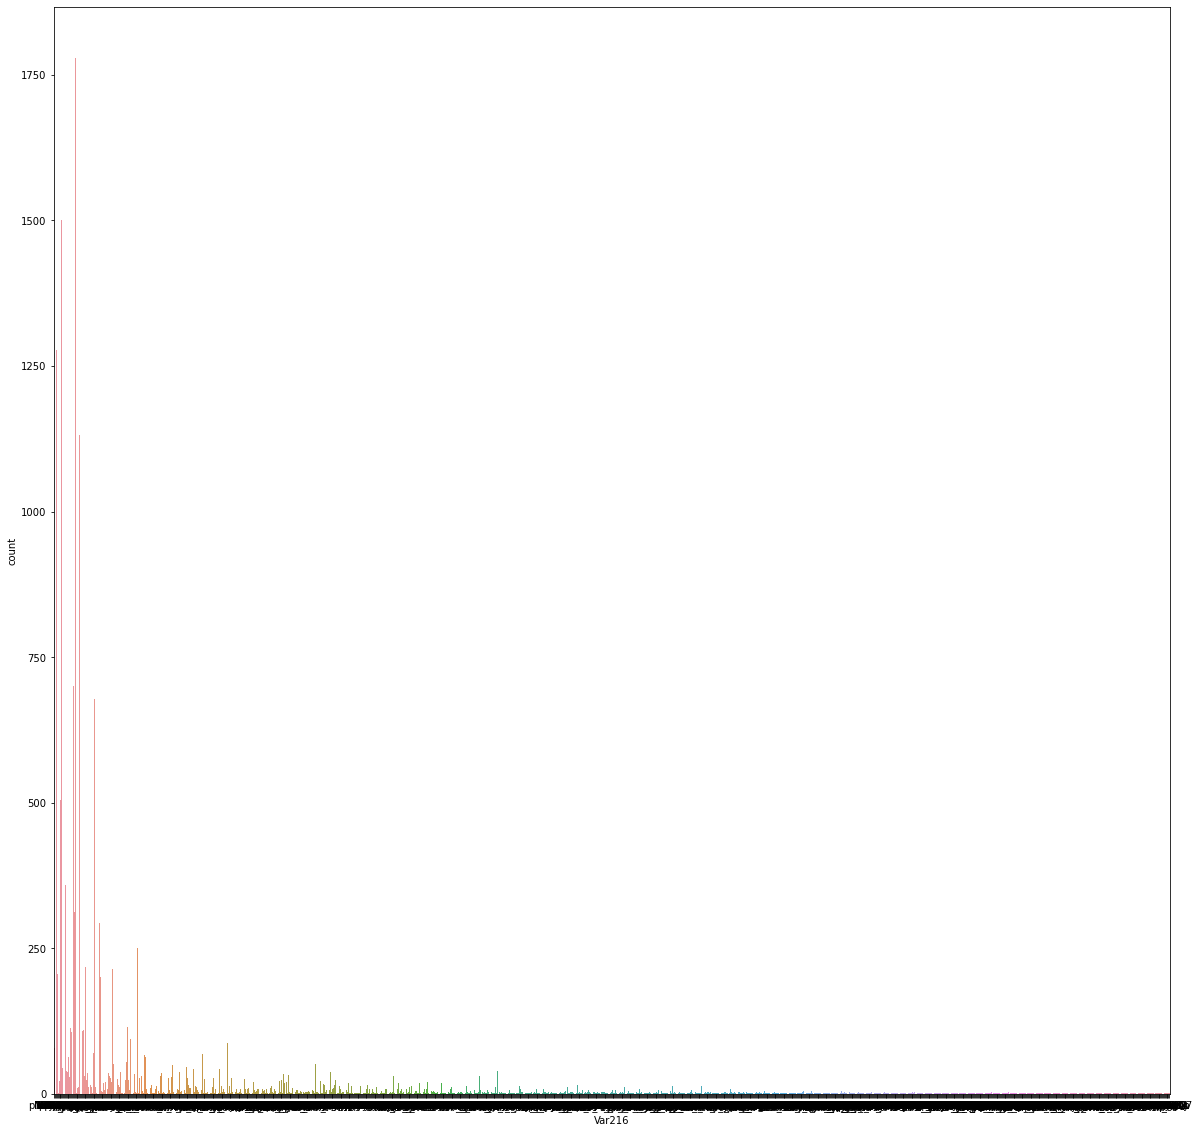

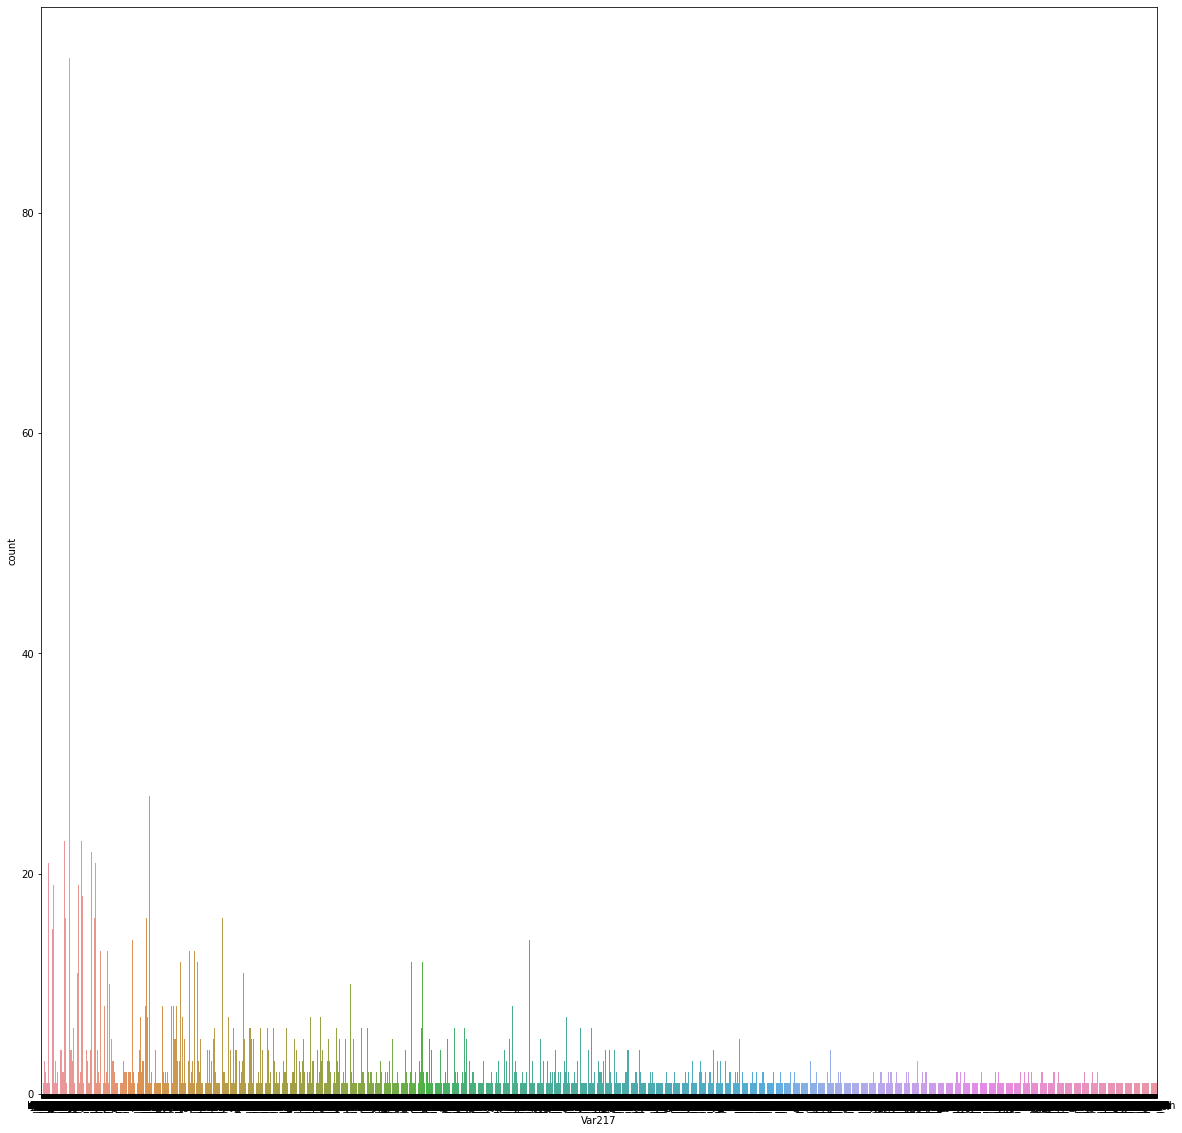

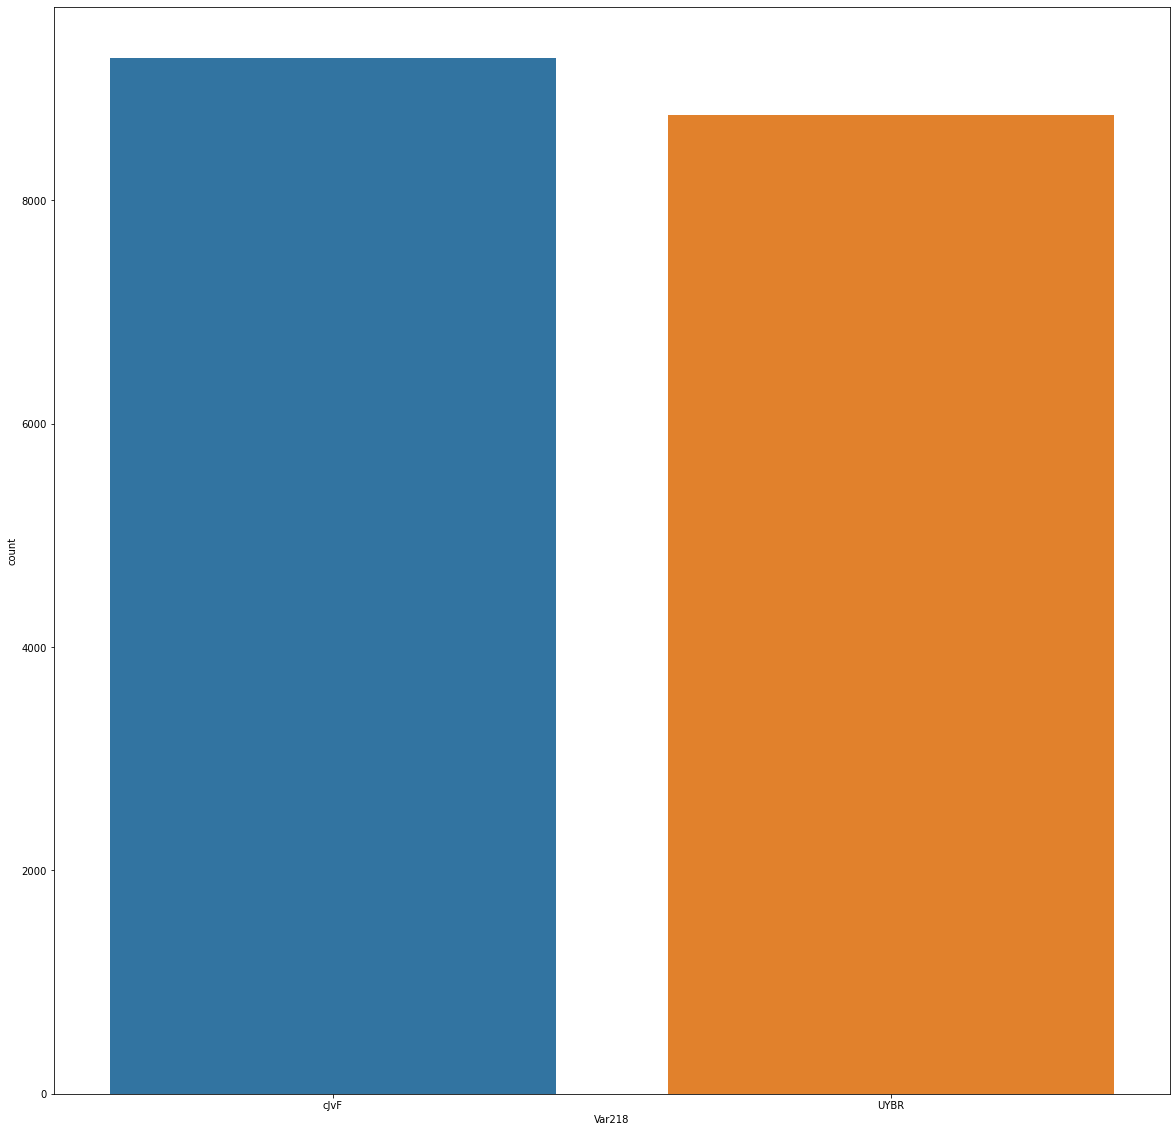

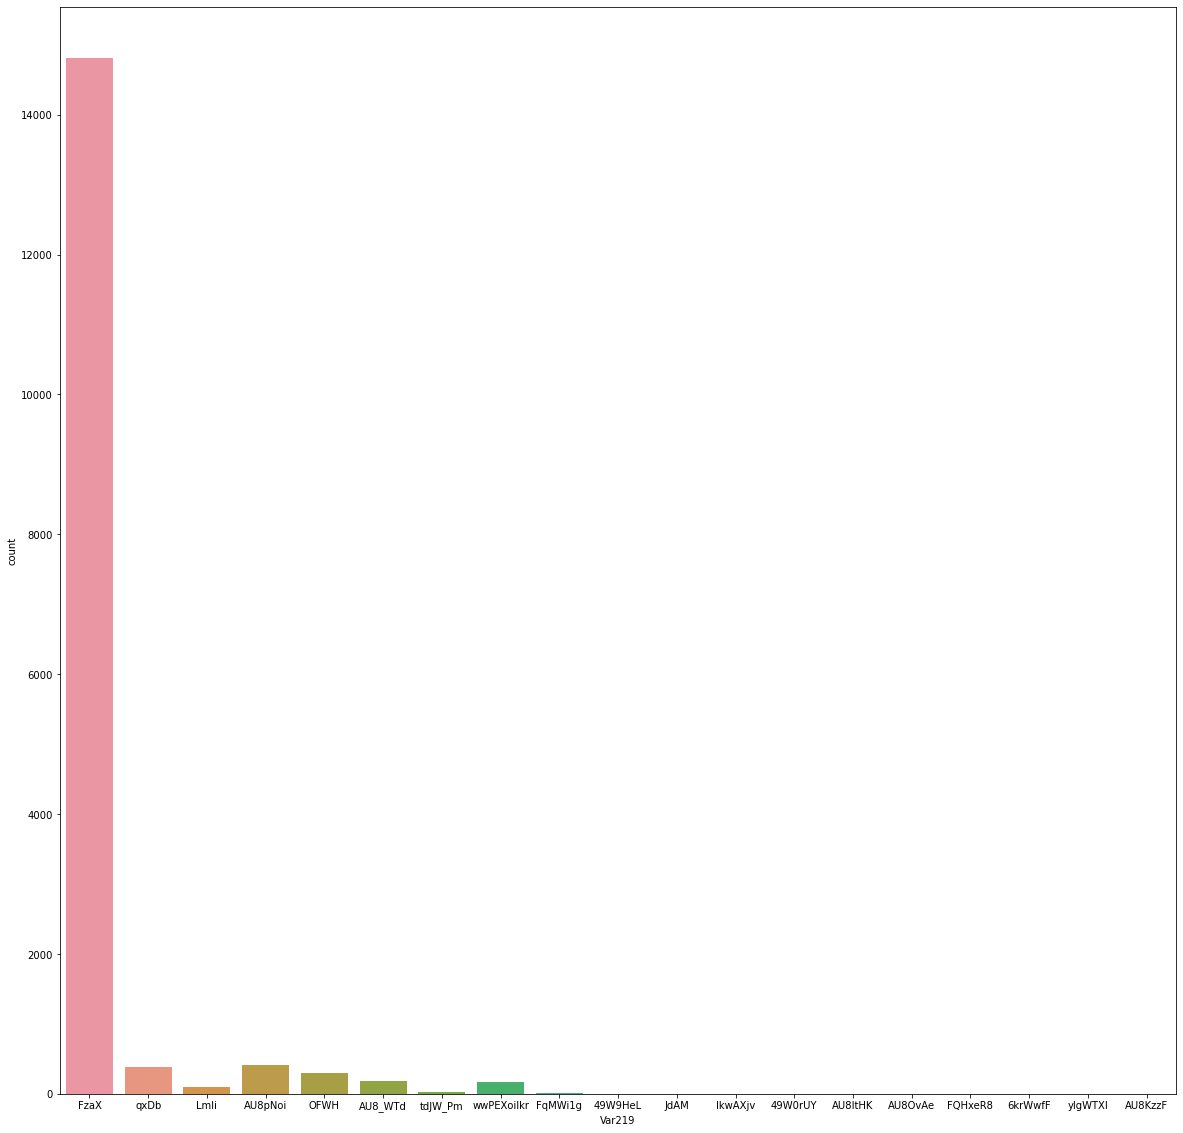

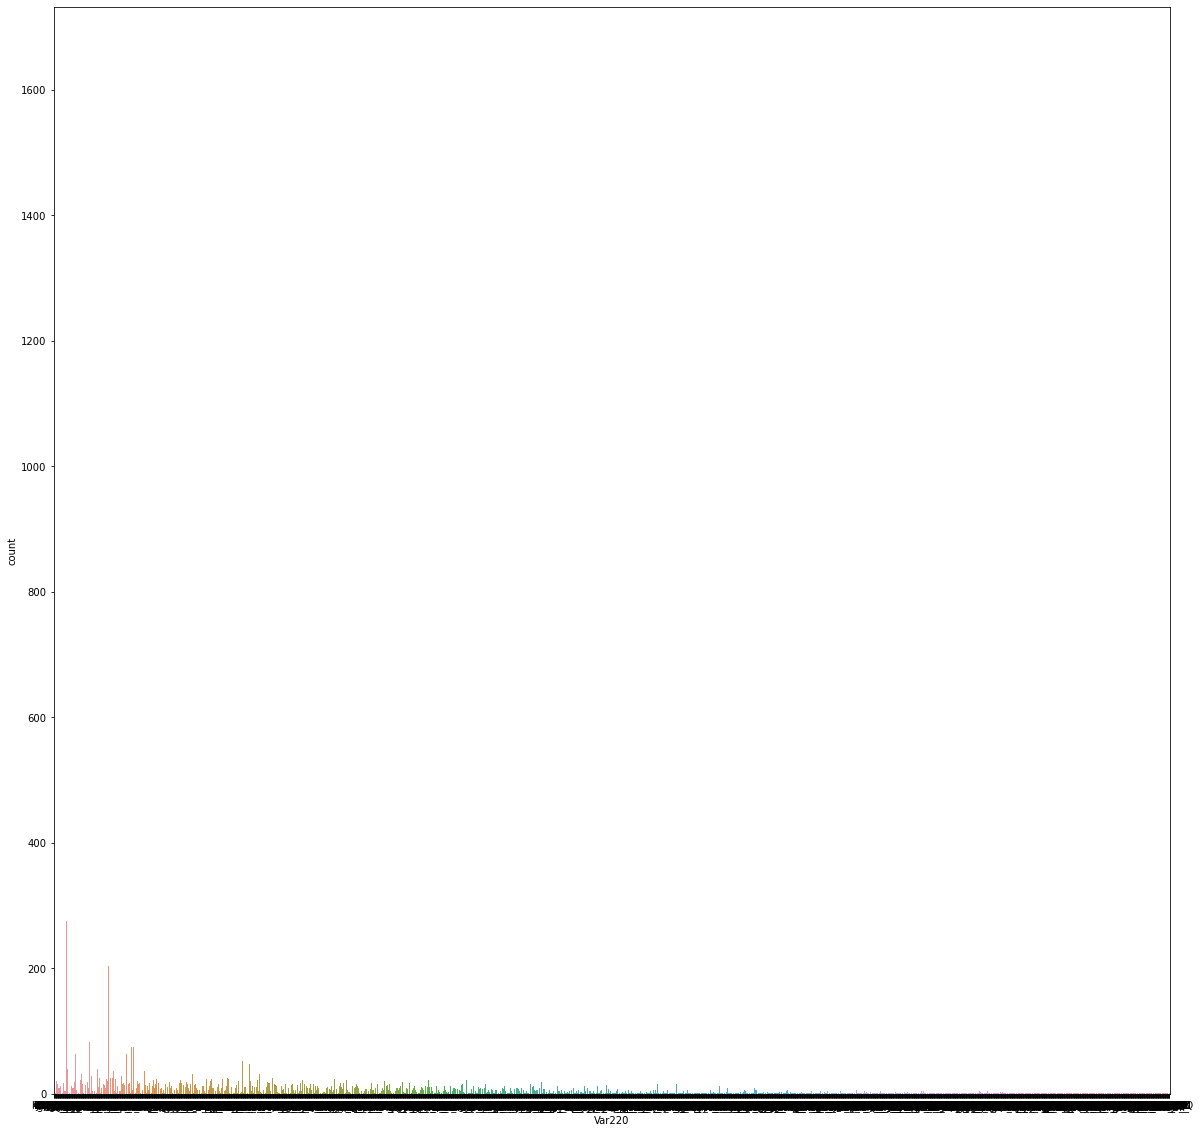

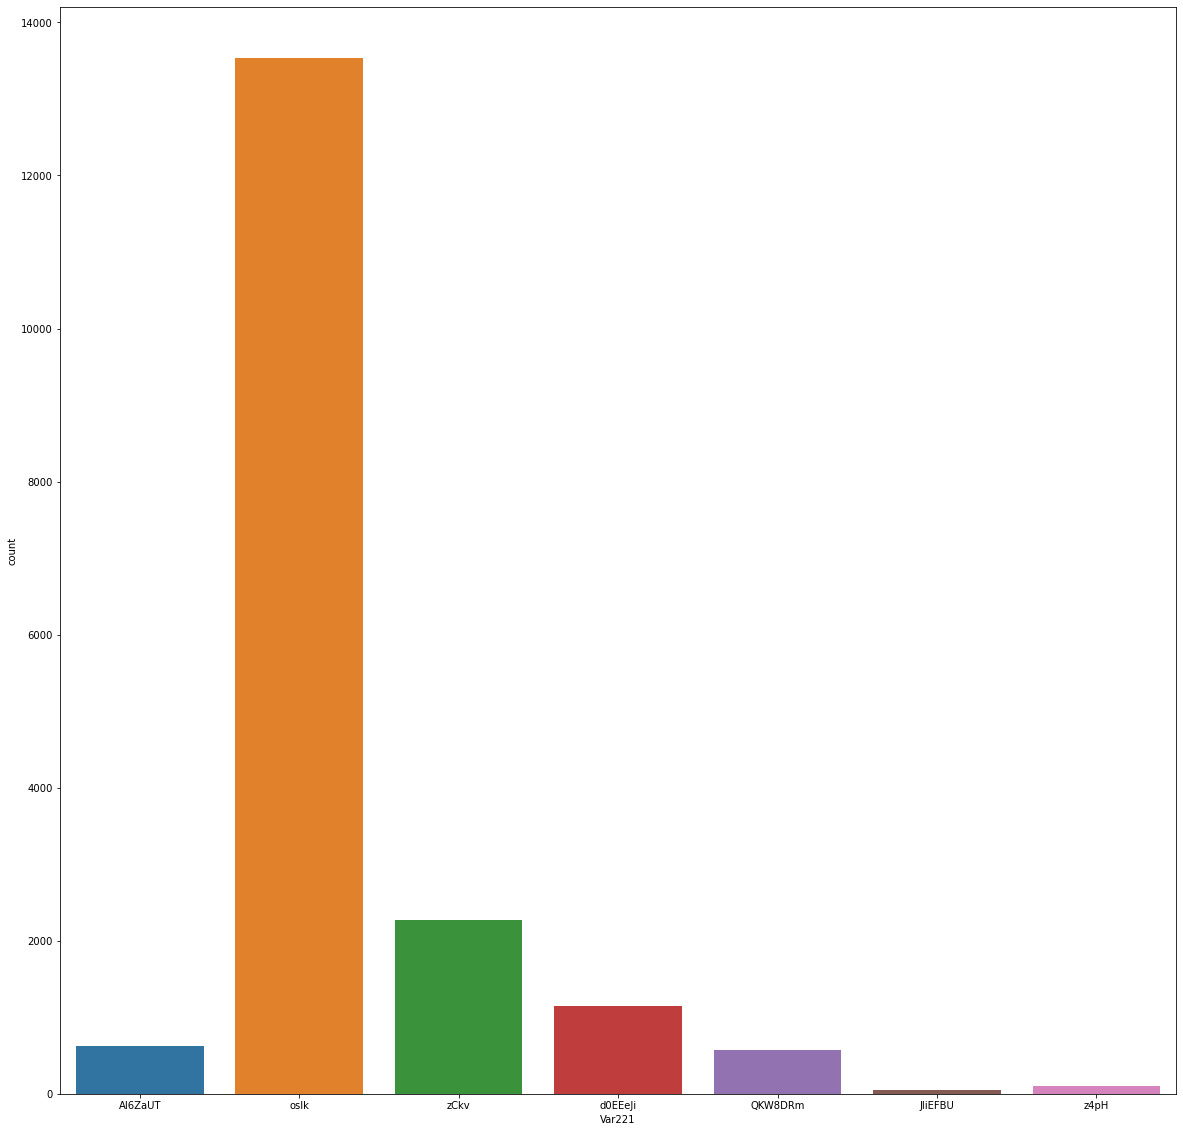

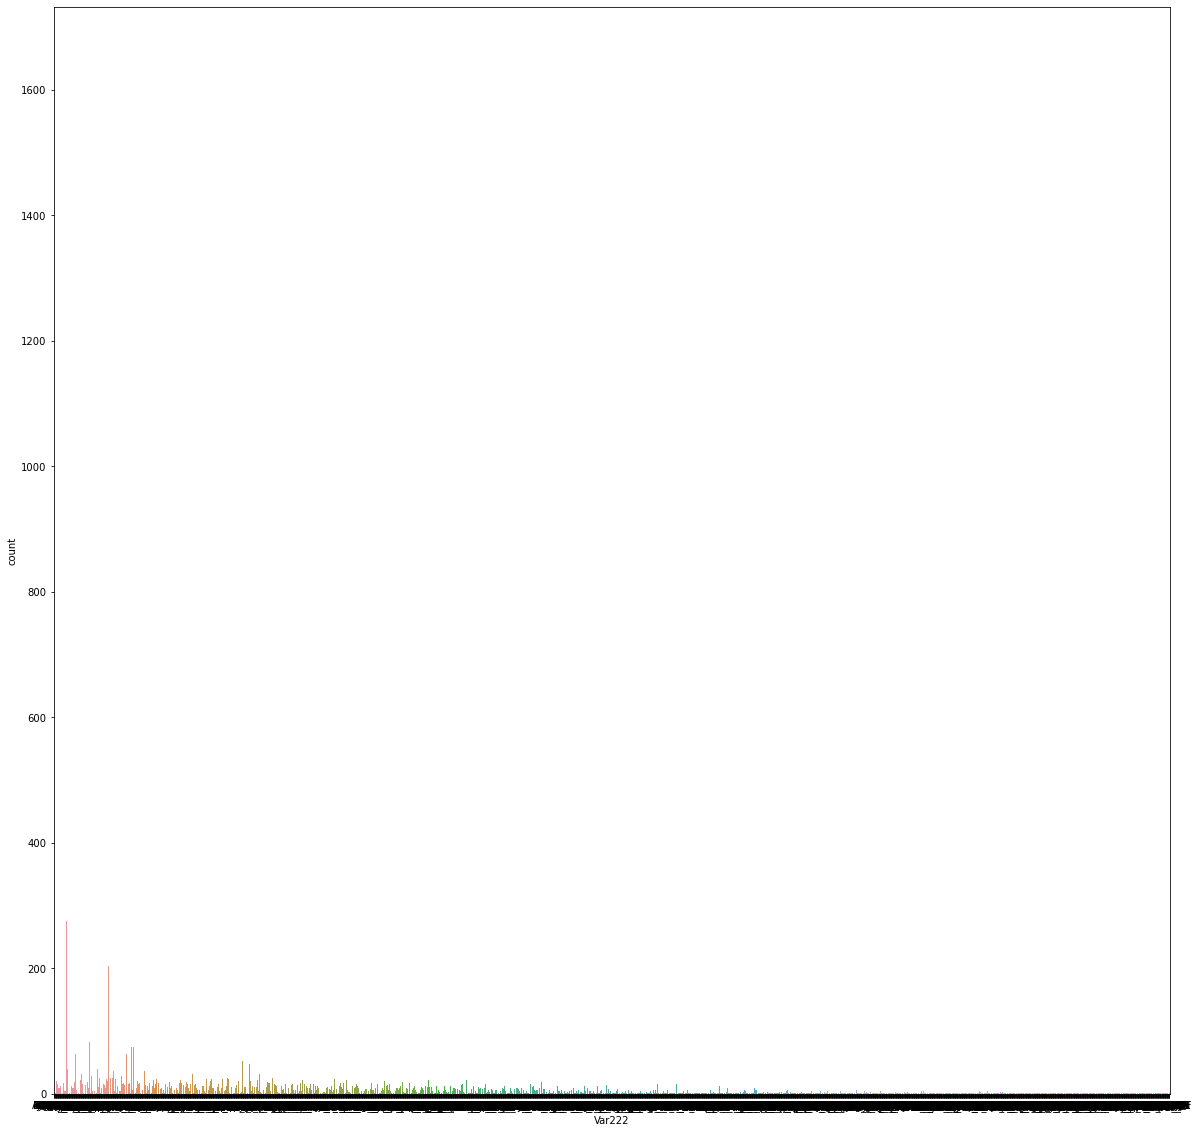

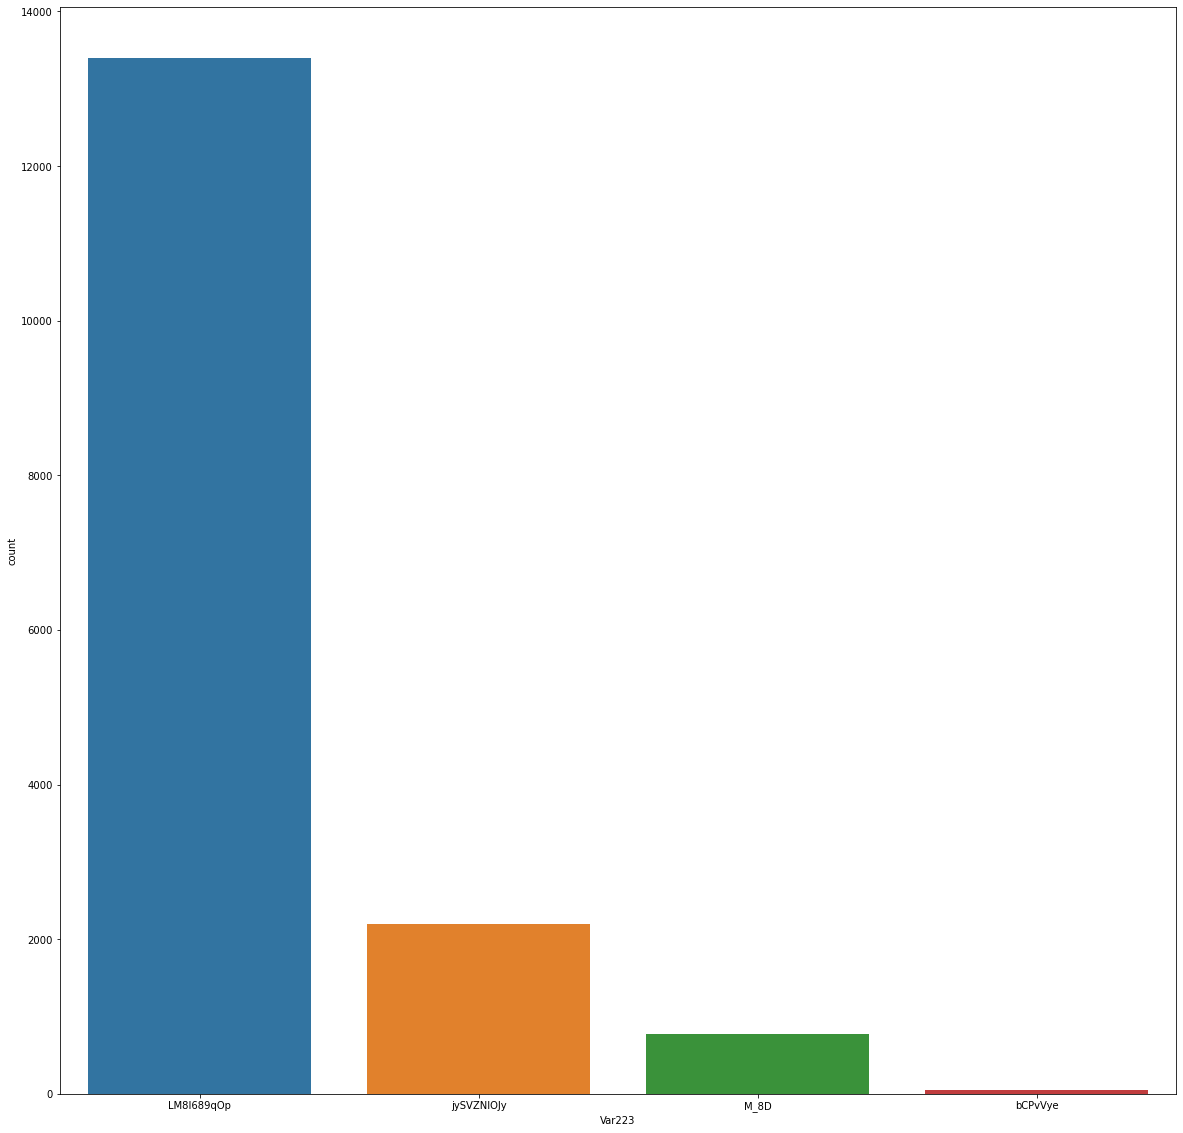

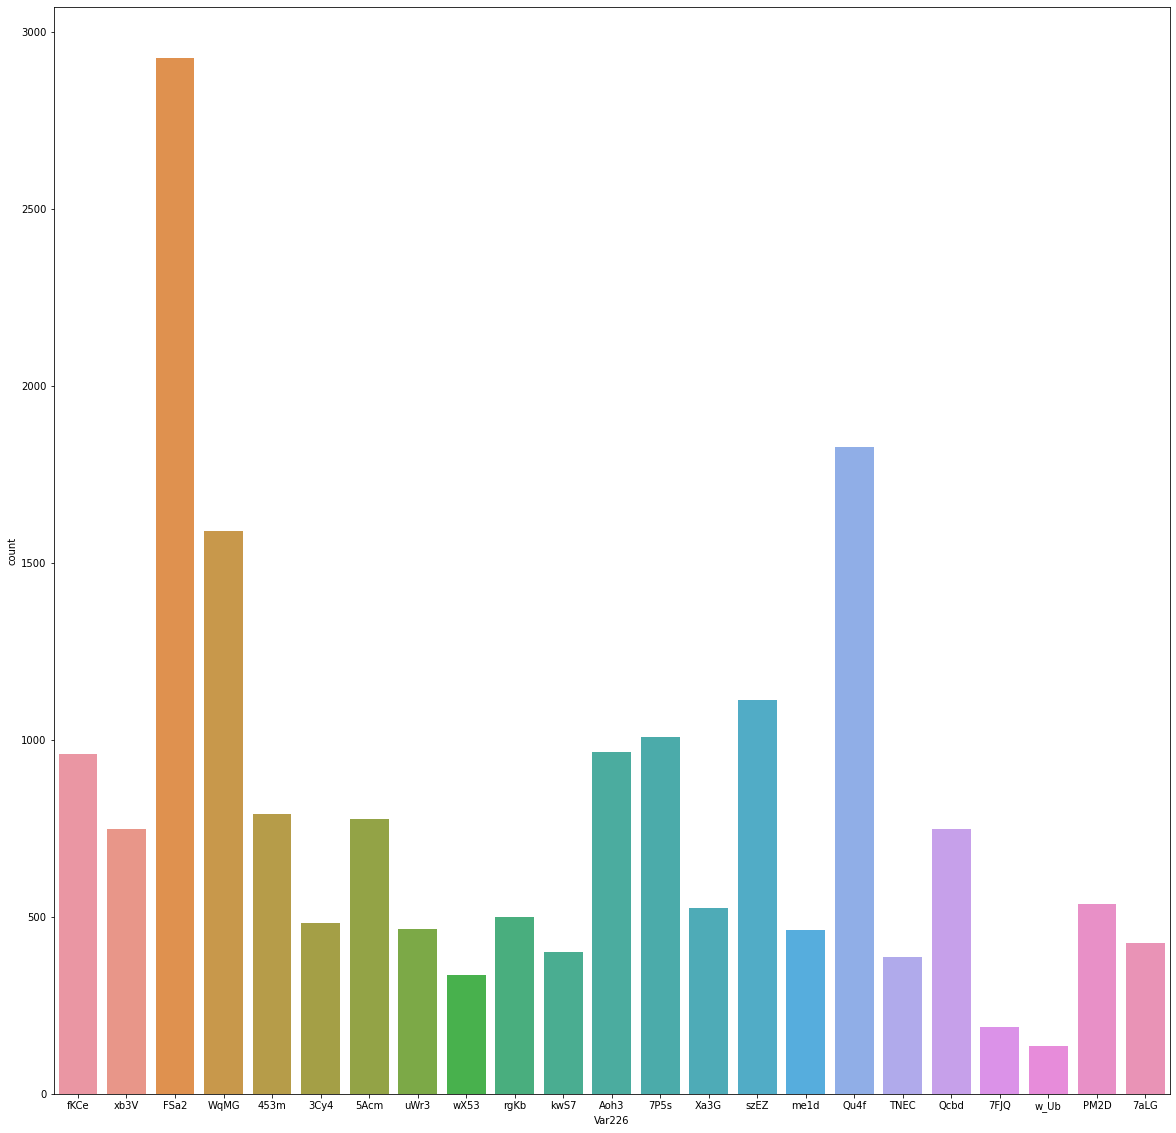

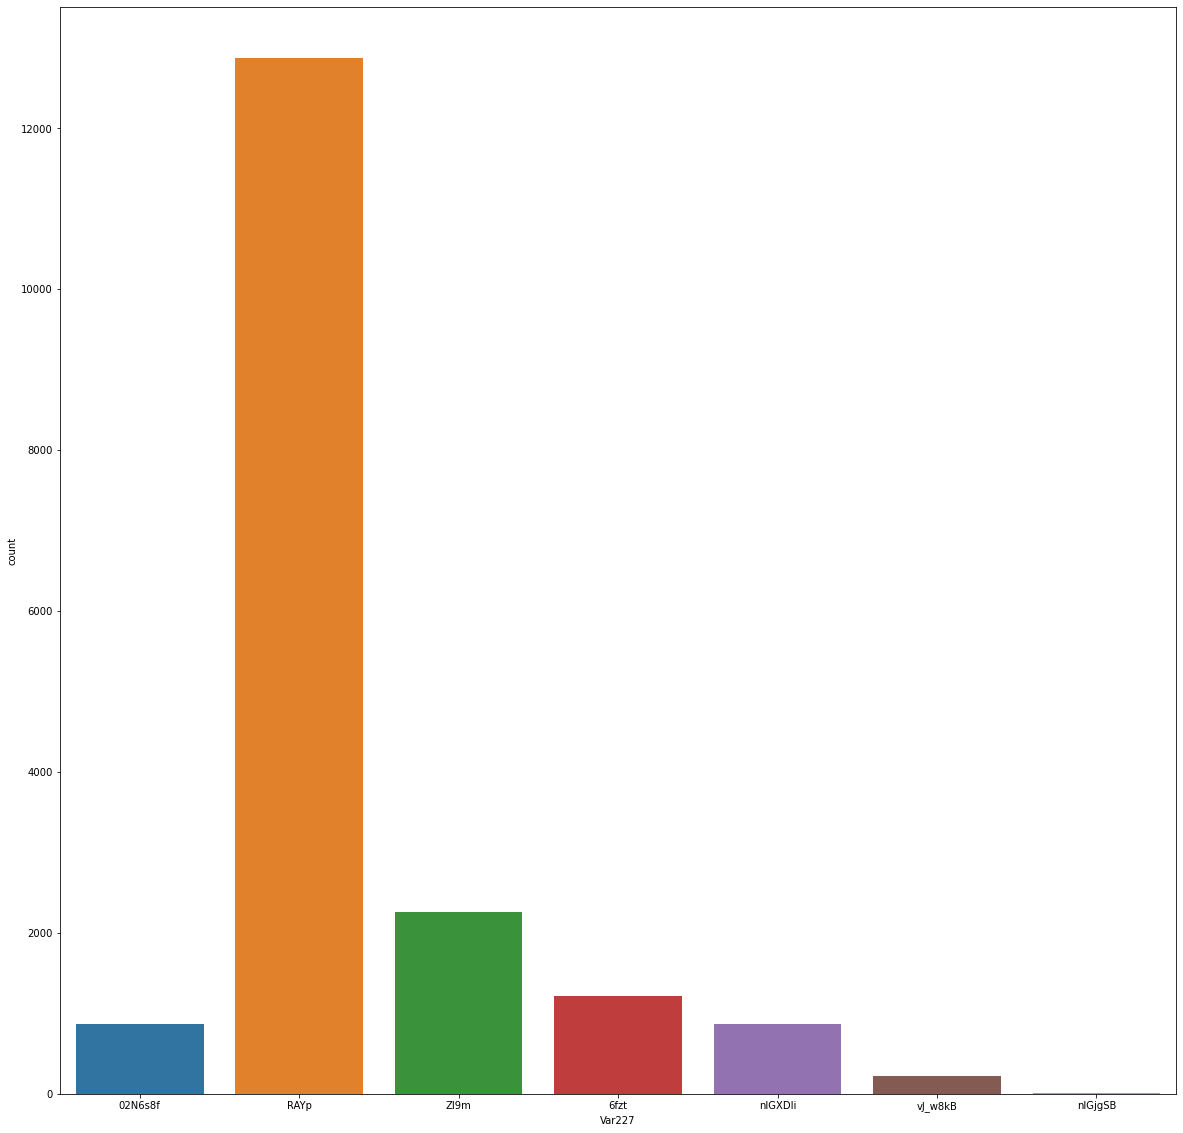

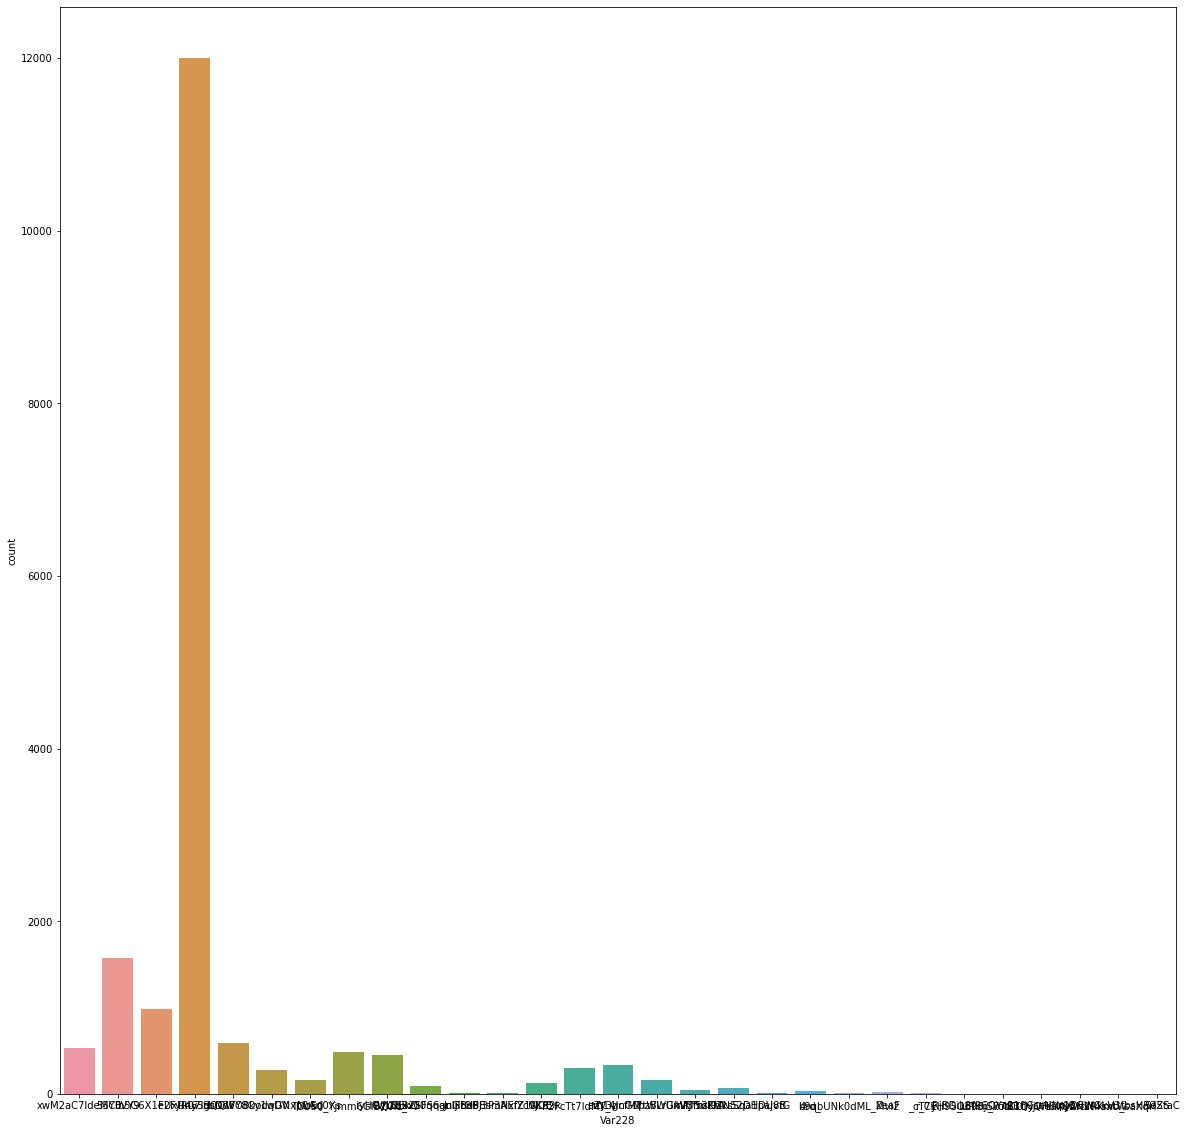

In [25]:
for name in right_cat_column:
    plt.figure(figsize=(20,20))
    sns.countplot(x=name, data=data[right_cat_column])

In [28]:
for check_name in ['Var196', 'Var195']:
    print(check_name)
    print(data[check_name].value_counts())
    

Var196
1K8T    18130
z3mO      159
JA1C        8
mKeq        1
Name: Var196, dtype: int64
Var195
taul                17562
LfvqpCtLOY            297
CiJDdr4TQ0rGERIS      203
ev6I                   70
CuXi4je                65
b_3Q                   24
I9xt3GDRhUK7p          24
I9xt3GMcxUnBZ          11
I9xt3GBDKUbd8           9
ArtjQZmIvr94p           6
ArtjQZ8ftr3NB           6
lSbpiq1                 4
hiMqnEM7VgIk4JUu        4
BNjsq81k1tWAYigY        3
bsZtYxFjzA              3
ZZBPiZh                 2
ArtjQZQO1r9fC           1
F1JQrEL                 1
CiJsoa4TQ0rGHlMp        1
TnJpfvsJgF              1
V10_0kx3ZF2we           1
Name: Var195, dtype: int64


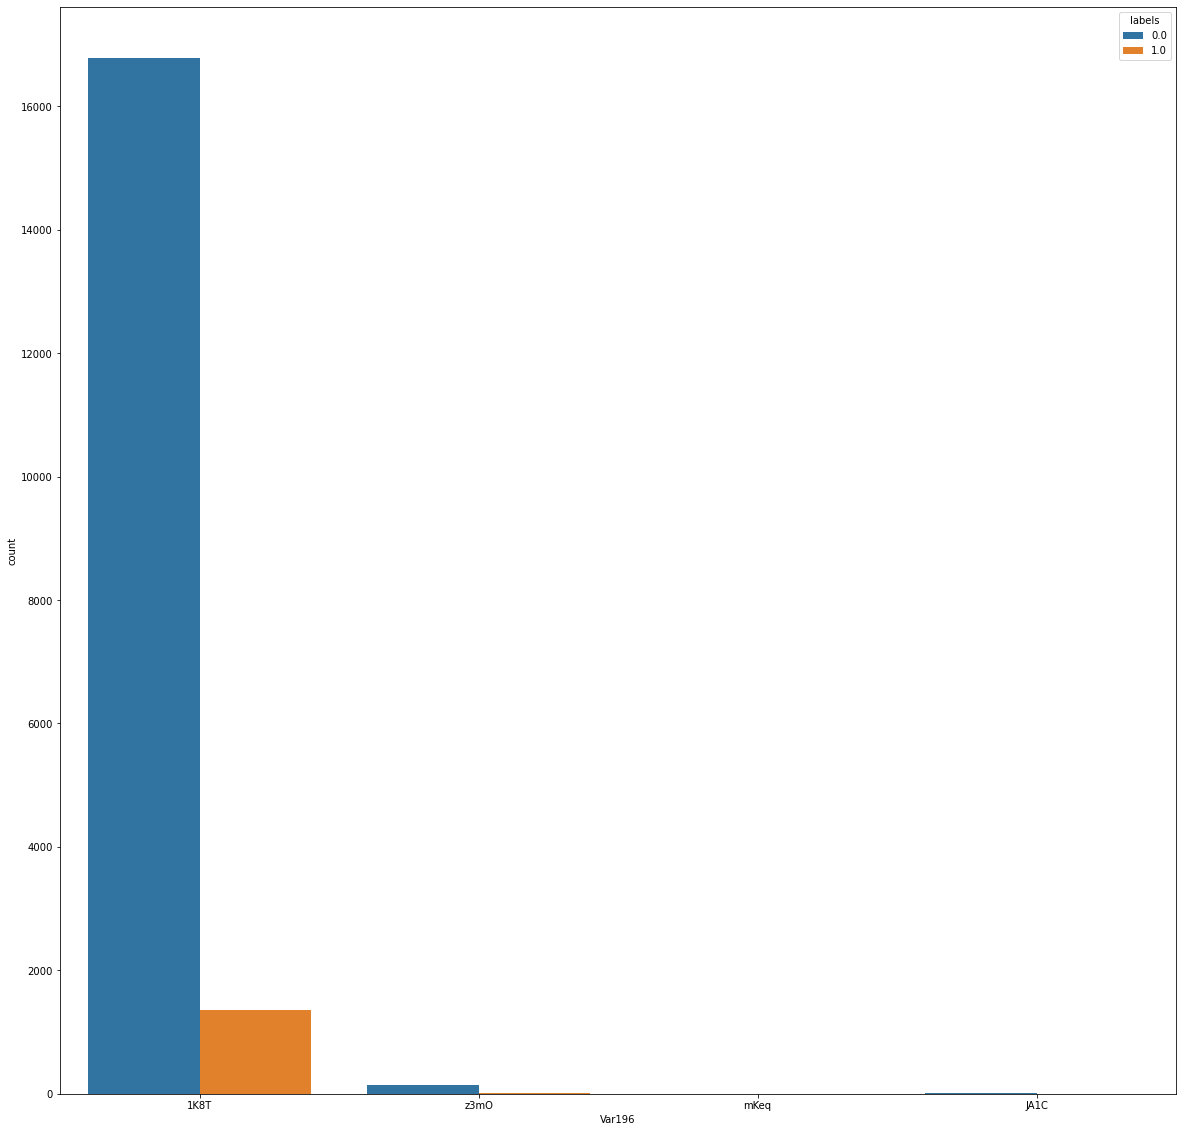

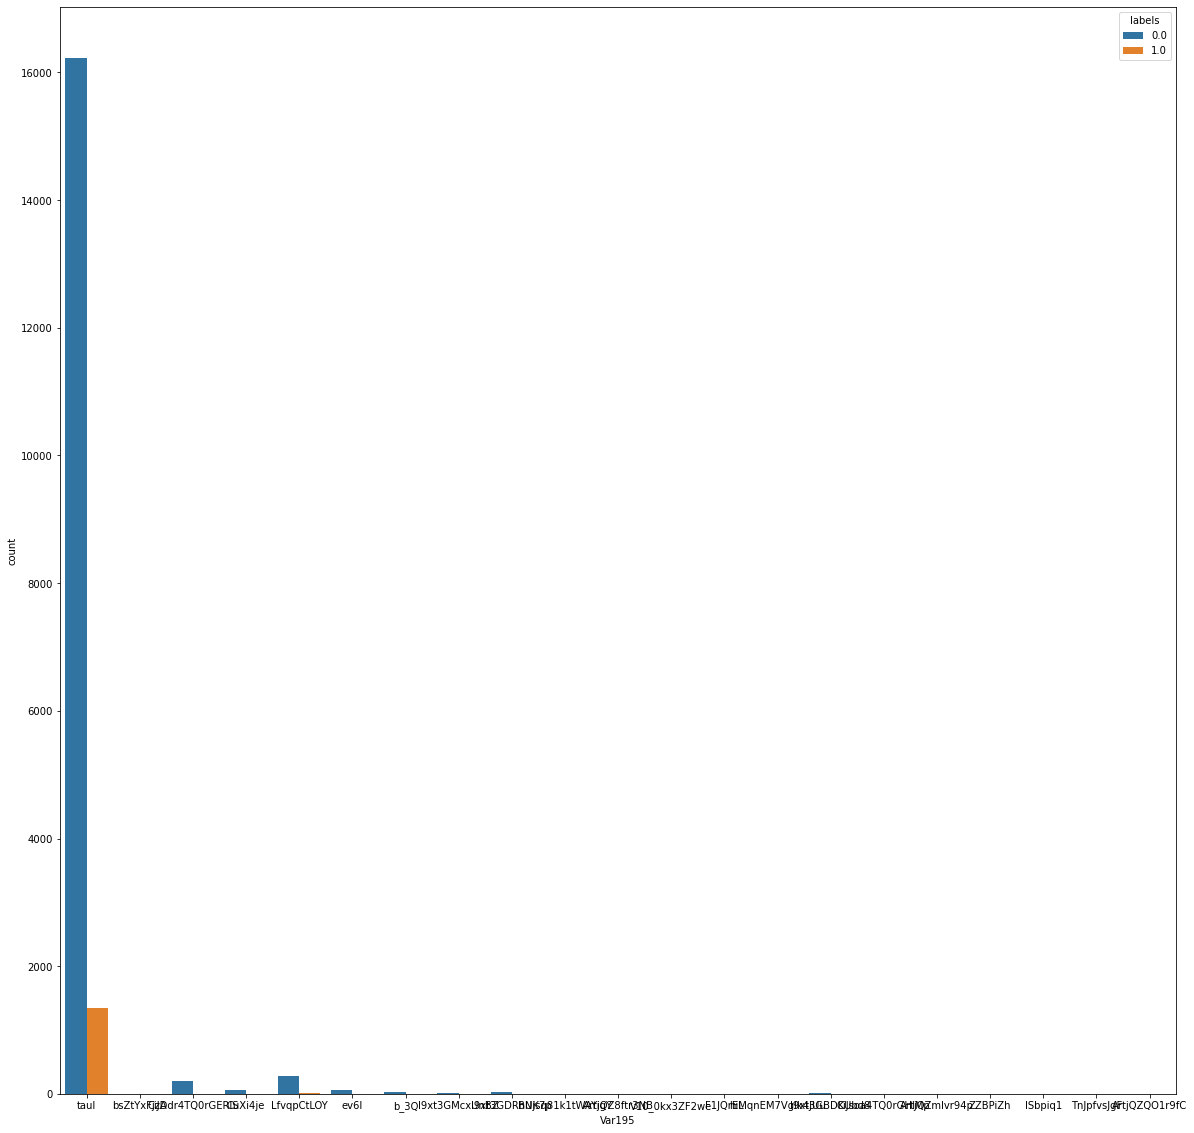

In [31]:
for check_name in ['Var196', 'Var195']:
    plt.figure(figsize=(20,20))
    sns.countplot(x=check_name, data=data[right_cat_column], hue = labels)

this feature is almost constant, it should drop from data

In [69]:
right_cat_column_1 = right_cat_column[~right_cat_column.isin(['Var196', 'Var195'])]

Correlation between feature and target